In [594]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import PCA, TruncatedSVD
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA

from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC

from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

import pickle

%matplotlib inline

## [Section 1: Real or Not? NLP with Disaster Tweets]
### Build a machine learning model that predicts which Tweets are about real disasters and which one’s aren’t. 

## [Section 2: Project Definition]
### Goal
Build a classifier to determine if a tweet is about a disaster
### Dataset - Kaggle
https://www.kaggle.com/c/nlp-getting-started/overview
### Tasks 
1. Create new features from text data
2. Exploratory data analysis - Understanding the features
3. Create pipelines for simplifying the workflow
4. Do GridSearchCV across pre-processing of text (lemm and stem), vectorizations, models, and hyperparamters
5. Evaluation metrics
6. Submission on Kaggle
7. Improvements

## [Section 3 and 4: Data Engineering and Feature Enginerring]

In [455]:
df = pd.read_csv('train.csv')
df.head()

id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target  
0       1  
1       1  
2       1  
3       1  
4       1

In [456]:
df.shape

(7613, 5)

In [457]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
id          7613 non-null int64
keyword     7552 non-null object
location    5080 non-null object
text        7613 non-null object
target      7613 non-null int64
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [458]:
#Not goint to use "keyword" as a feature. It looks like the tweets were taken from keywords across different disaster topics
print(df.keyword.value_counts())

fatalities               45
armageddon               42
deluge                   42
harm                     41
damage                   41
body%20bags              41
sinking                  41
twister                  40
windstorm                40
siren                    40
outbreak                 40
fear                     40
collided                 40
evacuate                 40
wrecked                  39
sunk                     39
famine                   39
whirlwind                39
wreckage                 39
derailment               39
earthquake               39
hellfire                 39
collision                39
explosion                39
weapon                   39
sinkhole                 39
flames                   39
weapons                  39
fatal                    38
flooding                 38
                         ..
devastated               31
wild%20fires             31
terrorist                31
survivors                30
avalanche           

In [459]:
#For a few countries, there is only 1 tweet from that location. We will not use location as we want to train the model
#to identify disaster tweets irrespective of location of the tweet. 
#If there were more data across location, we may choose the feature as the model may learn to identify tweet patterns from
#different locations
pd.DataFrame(df['location'].value_counts())

location
USA                                104
New York                            71
United States                       50
London                              45
Canada                              29
Nigeria                             28
UK                                  27
Los Angeles, CA                     26
India                               24
Mumbai                              22
Washington, DC                      21
Kenya                               20
Worldwide                           19
Australia                           18
Chicago, IL                         18
California                          17
California, USA                     15
New York, NY                        15
Everywhere                          15
San Francisco                       14
Florida                             14
United Kingdom                      14
Indonesia                           13
Washington, D.C.                    13
Los Angeles                         13
Ireland                             12
NYC                                 12
Toronto                             12
Seattle                             11
Earth                               11
...                                ...
Republica Dominicana                 1
Û¢OlderCandyBloomÛ¢                1
Lima-Peru                            1
WestEnd, Puritan Ave                 1
kano                                 1
Geneva. And beyond.                  1
Why should you know?                 1
ÌÏT: 40.707762,-74.014213            1
Queens New York                      1
ÌÏT: 43.631838,-79.55807             1
Playa                                1
UAE,Sharjah/ AbuDhabi                1
they/them                            1
WORLDWIDE-BOSTON                     1
#BlackLivesMatter                    1
Spokane, Washington 99206            1
dope show                            1
Dhaka                                1
Fredericksburg, Virginia             1
jersey                               1
Leeds, UK                            1
Maricopa, AZ                         1
Glenview to Knoxville                1
H / pez & sophia                     1
Australian Capital Territory         1
? miranda ? 521 mi                   1
london town..                        1
on the web                           1
Quincy                               1
Irving , Texas                       1

[3341 rows x 1 columns]

In [460]:
pd.DataFrame(df['location'].value_counts()).info()

<class 'pandas.core.frame.DataFrame'>
Index: 3341 entries, USA to Irving , Texas
Data columns (total 1 columns):
location    3341 non-null int64
dtypes: int64(1)
memory usage: 52.2+ KB


In [461]:
df.target.value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [581]:
#Asumming stratification, a dumb model that always predicts the majority class has the below accuracy
4342/sum(df.target.value_counts()) 

0.5703402075397347

In [462]:
#non-disaster tweets
df.text.loc[df['target']==0,]

15                                         What's up man?
16                                          I love fruits
17                                       Summer is lovely
18                                      My car is so fast
19                           What a goooooooaaaaaal!!!!!!
20                                 this is ridiculous....
21                                      London is cool ;)
22                                            Love skiing
23                                  What a wonderful day!
24                                               LOOOOOOL
25                         No way...I can't eat that shit
26                                  Was in NYC last week!
27                                     Love my girlfriend
28                                              Cooool :)
29                                     Do you like pasta?
30                                               The end!
32      We always try to bring the heavy. #metal #RT h...
34            

In [463]:
#disaster tweets
df.text.loc[df['target']==1,]

0       Our Deeds are the Reason of this #earthquake M...
1                  Forest fire near La Ronge Sask. Canada
2       All residents asked to 'shelter in place' are ...
3       13,000 people receive #wildfires evacuation or...
4       Just got sent this photo from Ruby #Alaska as ...
5       #RockyFire Update => California Hwy. 20 closed...
6       #flood #disaster Heavy rain causes flash flood...
7       I'm on top of the hill and I can see a fire in...
8       There's an emergency evacuation happening now ...
9       I'm afraid that the tornado is coming to our a...
10            Three people died from the heat wave so far
11      Haha South Tampa is getting flooded hah- WAIT ...
12      #raining #flooding #Florida #TampaBay #Tampa 1...
13                #Flood in Bago Myanmar #We arrived Bago
14      Damage to school bus on 80 in multi car crash ...
31      @bbcmtd Wholesale Markets ablaze http://t.co/l...
33      #AFRICANBAZE: Breaking news:Nigeria flag set a...
37      INEC O

# Creating features

In [464]:
#Add 14 new features
import re 
def url_count(text):
    return len(re.findall('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+',text))
def remove_url(text):
    return re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+','',text)

df_new = df
df_new['url_count'] = df_new.text.apply(lambda x: url_count(x))
df_new['text_nourl'] = df_new.text.apply(lambda x: remove_url(x))

df_new['char_len'] = df_new.text_nourl.str.len()
df_new['word_count'] = df_new.text_nourl.apply(lambda x: len(x.split()))
df_new['char_per_word'] = df_new.char_len/df_new.word_count

from nltk.corpus import stopwords
stop = stopwords.words('english')
df_new['stopwords_count'] = df_new.text_nourl.apply(lambda x: len([y for y in x.split() if y in stop]))

from textblob import TextBlob
df_new['polarity'] = df_new.text_nourl.map(lambda x: TextBlob(x).sentiment.polarity)
df_new['subjectivity'] = df_new.text_nourl.map(lambda x: TextBlob(x).sentiment.subjectivity)

#Creating seperate features for @, ! and . as these may be common characters in tweets
#punc_count will count all the punctuations, including @, ! and . 
df_new['#tweet_count'] = df_new.text_nourl.apply(lambda x: len(re.findall('#\w*[a-zA-Z]\w*', x))) 
df_new['#tweet_list'] = df_new.text_nourl.apply(lambda x: re.findall('#\w*[a-zA-Z]\w*', x)) 
df_new['@_count'] = df_new.text_nourl.apply(lambda x: x.count('@'))
df_new['!_count'] = df_new.text_nourl.apply(lambda x: x.count('!'))
df_new['._count'] = df_new.text_nourl.apply(lambda x: x.count('.'))
df_new['punc_count'] = df_new.text_nourl.apply(lambda x: len(re.findall('[.?"\'`\,\-\!:;\(\)\[\]\\/“”]+?', x)))

df_new['numerics_count'] = df_new.text_nourl.apply(lambda x: len([y for y in x.split() if y.isdigit()]))
df_new['uppercaseword_count'] = df_new.text_nourl.apply(lambda x: len([y for y in x.split() if y.isupper()]))

#Later we will create the document-term matrix using text_nourl_lowercase_nopunc
df_new['text_nourl_lowercase_nopunc'] = df_new.text_nourl.apply(lambda x: re.sub(r'[^\w\s]', '', x.lower()))

df_new['target_str'] = df_new.target.apply(lambda x: '1_disaster' if x==1 else '0_non_disaster')
df_new

id keyword location  \
0         1     NaN      NaN   
1         4     NaN      NaN   
2         5     NaN      NaN   
3         6     NaN      NaN   
4         7     NaN      NaN   
5         8     NaN      NaN   
6        10     NaN      NaN   
7        13     NaN      NaN   
8        14     NaN      NaN   
9        15     NaN      NaN   
10       16     NaN      NaN   
11       17     NaN      NaN   
12       18     NaN      NaN   
13       19     NaN      NaN   
14       20     NaN      NaN   
15       23     NaN      NaN   
16       24     NaN      NaN   
17       25     NaN      NaN   
18       26     NaN      NaN   
19       28     NaN      NaN   
20       31     NaN      NaN   
21       32     NaN      NaN   
22       33     NaN      NaN   
23       34     NaN      NaN   
24       36     NaN      NaN   
25       37     NaN      NaN   
26       38     NaN      NaN   
27       39     NaN      NaN   
28       40     NaN      NaN   
29       41     NaN      NaN   
...     ...     ...      ...   
7583  10835     NaN      NaN   
7584  10837     NaN      NaN   
7585  10839     NaN      NaN   
7586  10840     NaN      NaN   
7587  10841     NaN      NaN   
7588  10842     NaN      NaN   
7589  10843     NaN      NaN   
7590  10844     NaN      NaN   
7591  10846     NaN      NaN   
7592  10847     NaN      NaN   
7593  10848     NaN      NaN   
7594  10849     NaN      NaN   
7595  10850     NaN      NaN   
7596  10851     NaN      NaN   
7597  10852     NaN      NaN   
7598  10853     NaN      NaN   
7599  10854     NaN      NaN   
7600  10855     NaN      NaN   
7601  10859     NaN      NaN   
7602  10860     NaN      NaN   
7603  10862     NaN      NaN   
7604  10863     NaN      NaN   
7605  10864     NaN      NaN   
7606  10866     NaN      NaN   
7607  10867     NaN      NaN   
7608  10869     NaN      NaN   
7609  10870     NaN      NaN   
7610  10871     NaN      NaN   
7611  10872     NaN      NaN   
7612  10873     NaN      NaN   

                                                   text  target  url_count  \
0     Our Deeds are the Reason of this #earthquake M...       1          0   
1                Forest fire near La Ronge Sask. Canada       1          0   
2     All residents asked to 'shelter in place' are ...       1          0   
3     13,000 people receive #wildfires evacuation or...       1          0   
4     Just got sent this photo from Ruby #Alaska as ...       1          0   
5     #RockyFire Update => California Hwy. 20 closed...       1          0   
6     #flood #disaster Heavy rain causes flash flood...       1          0   
7     I'm on top of the hill and I can see a fire in...       1          0   
8     There's an emergency evacuation happening now ...       1          0   
9     I'm afraid that the tornado is coming to our a...       1          0   
10          Three people died from the heat wave so far       1          0   
11    Haha South Tampa is getting flooded hah- WAIT ...       1          0   
12    #raining #flooding #Florida #TampaBay #Tampa 1...       1          0   
13              #Flood in Bago Myanmar #We arrived Bago       1          0   
14    Damage to school bus on 80 in multi car crash ...       1          0   
15                                       What's up man?       0          0   
16                                        I love fruits       0          0   
17                                     Summer is lovely       0          0   
18                                    My car is so fast       0          0   
19                         What a goooooooaaaaaal!!!!!!       0          0   
20                               this is ridiculous....       0          0   
21                                    London is cool ;)       0          0   
22                                          Love skiing       0          0   
23                                What a wonderful day!       0          0   
24                                             LOOOOOOL       0          0

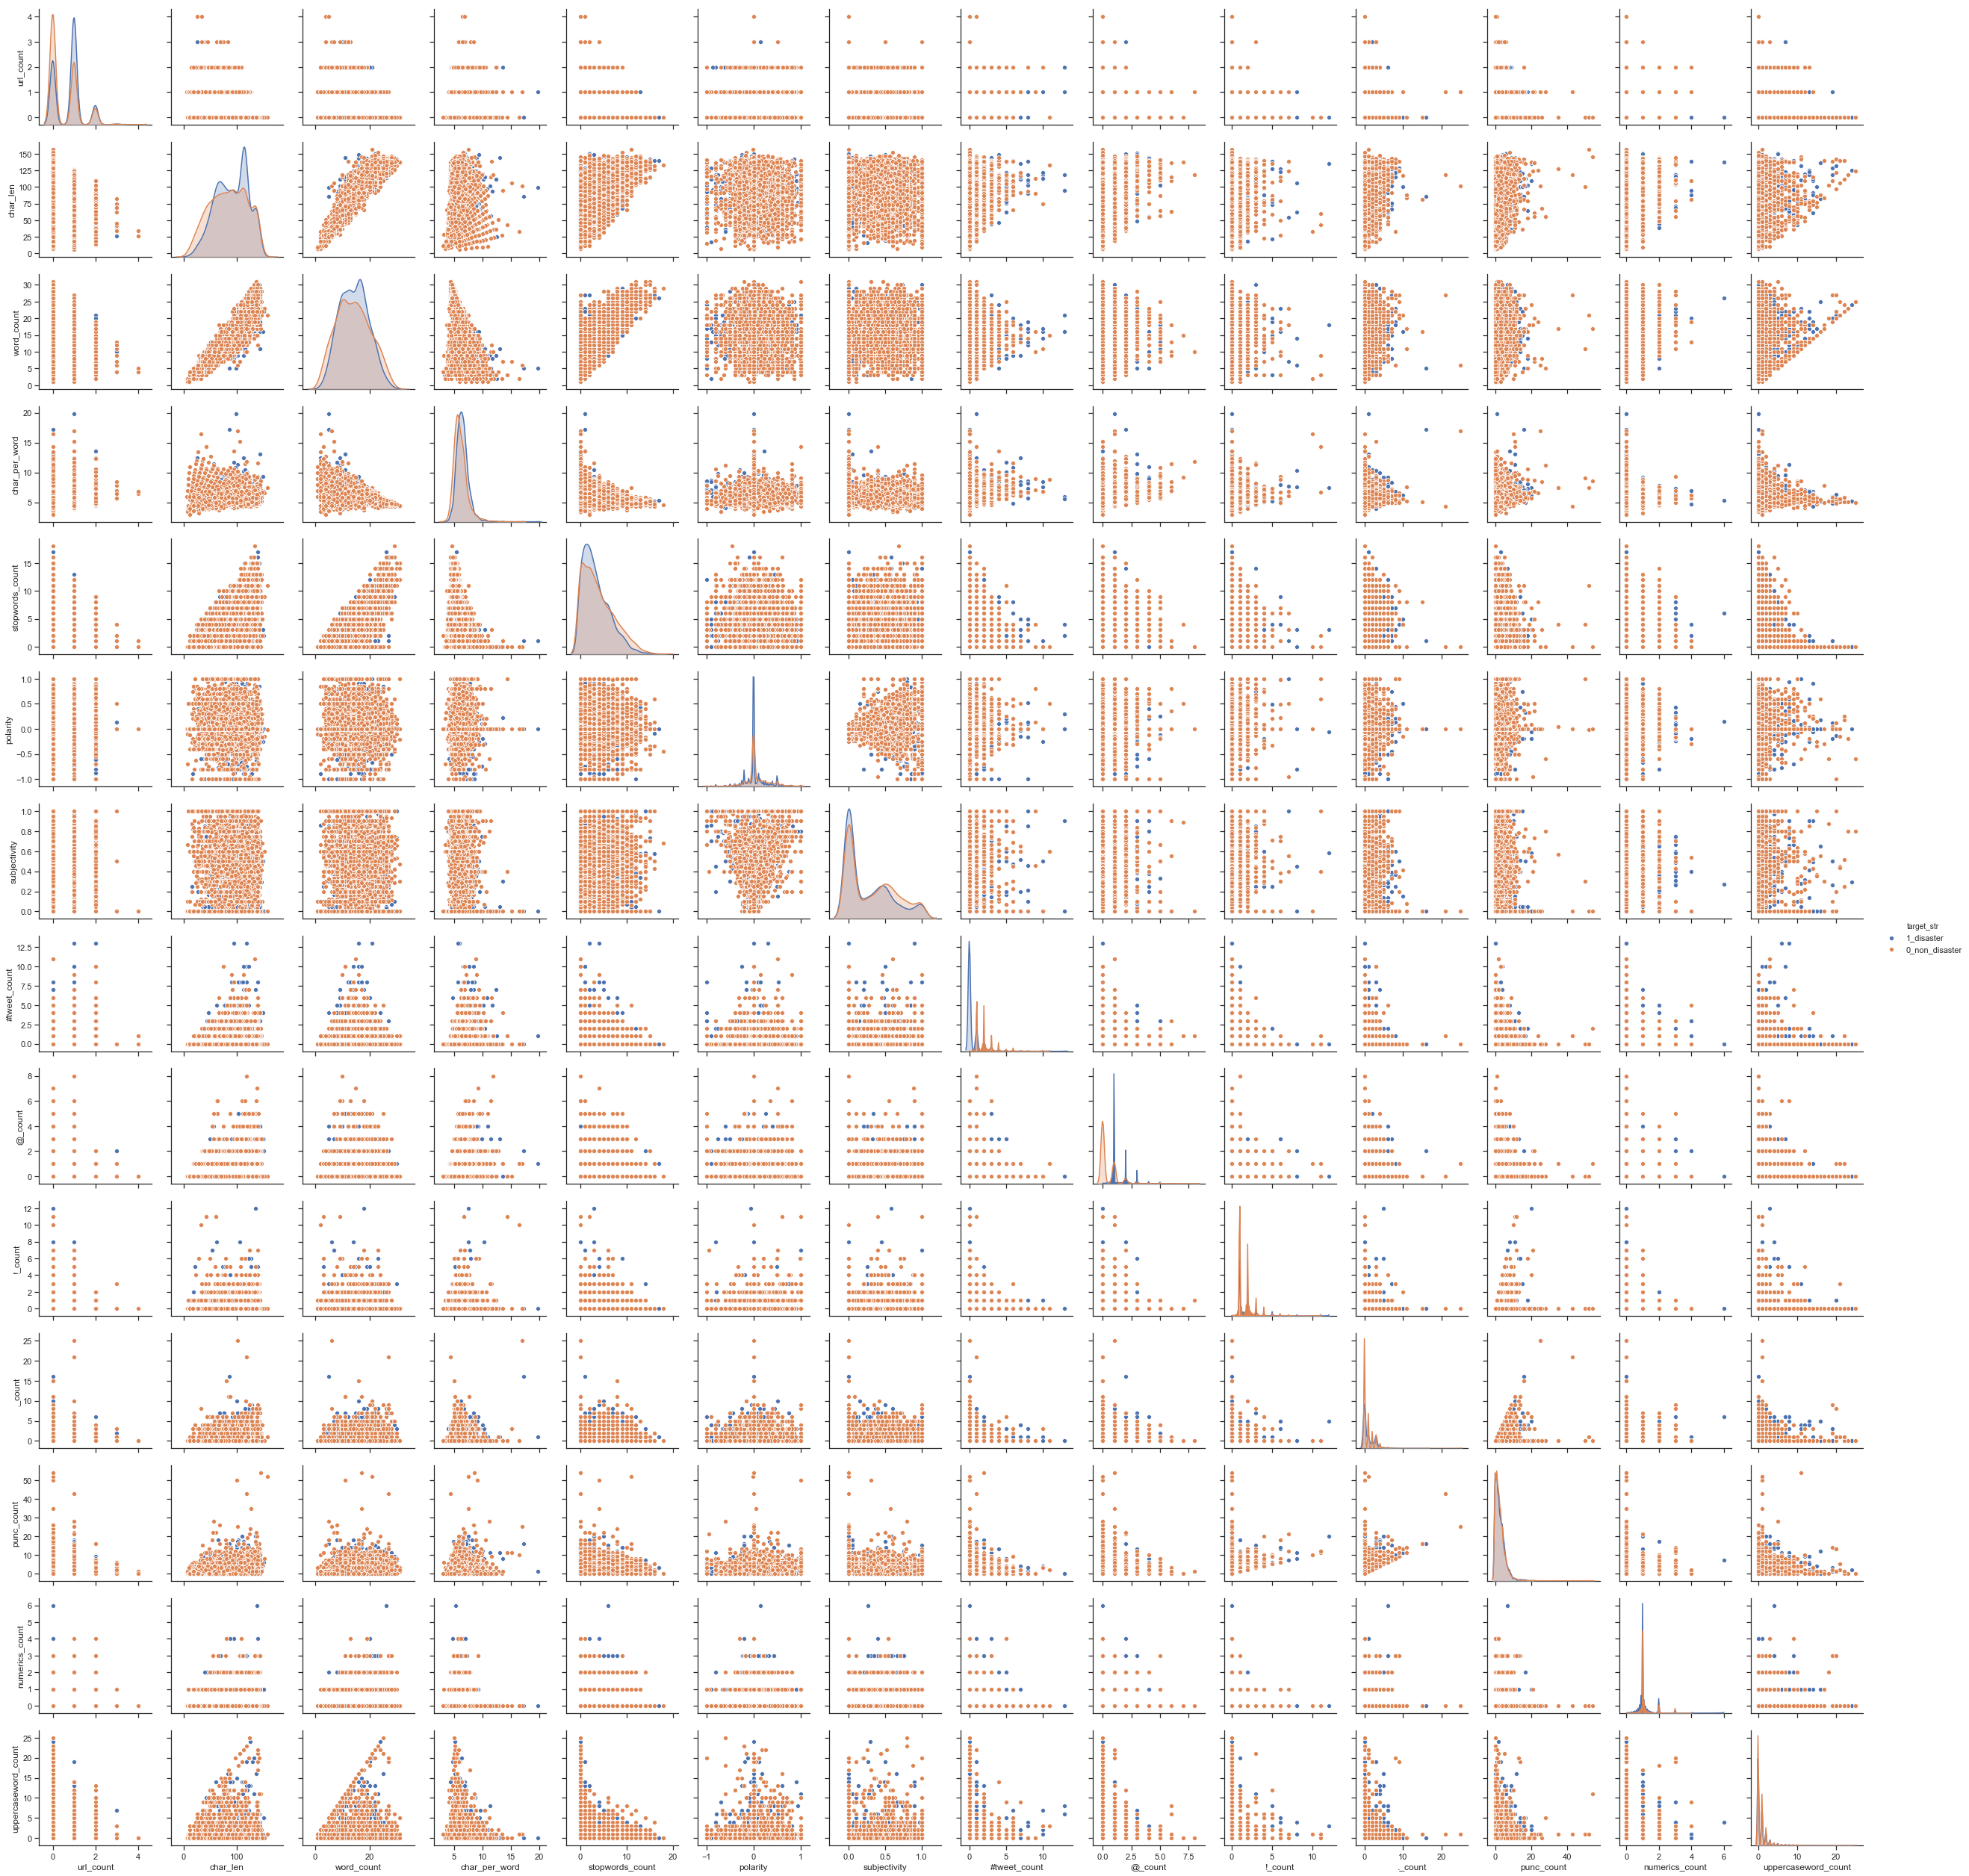

In [465]:
sns.pairplot(df_new.loc[:,['target_str','url_count','char_len','word_count', 'char_per_word', 'stopwords_count', 'polarity', 'subjectivity','#tweet_count', '@_count', '!_count','._count', 'punc_count', 'numerics_count', 'uppercaseword_count']], hue = 'target_str')

In [466]:
#Function for uni-variate analysis
#closer examination of the difference in distribution of the targets for some features
def plot_univariate(feature):
    f, axes = plt.subplots(1, 2, figsize=(14, 4), sharex=True, sharey=True)
    sns.distplot(df_new[df_new['target']==0][feature].values,kde=False,bins=30,hist=True,ax=axes[0],label="Histogram of 0_non_disaster (30 bins)", color = 'darkorange', hist_kws=dict(edgecolor="k"))
    sns.distplot(df_new[df_new['target']==1][feature].values,kde=False,bins=30,hist=True,ax=axes[1],label="Histogram of 1_disaster (30 bins)",hist_kws=dict(edgecolor="k"))

    f.suptitle("Histogram of " + feature, fontsize=20)
    axes[0].set_ylabel("Number of tweets")
    axes[0].set_xlabel(feature)
    axes[1].set_xlabel(feature)
    axes[0].legend()
    axes[1].legend()
    
    
    f, axes = plt.subplots(3,1, figsize=(14,5), sharex=True, gridspec_kw={"height_ratios": (.10,.10,.80)})
    sns.boxplot(df_new[df_new['target']==0][feature].values, ax=axes[0], color = 'orange')
    sns.boxplot(df_new[df_new['target']==1][feature].values, ax=axes[1])
    ax_box.set(yticks=[])
    sns.despine(ax=axes[0], left=True)
    sns.despine(ax=axes[1], left=True)
    
    
    sns.distplot(df_new[df_new.target == 1][feature], kde=True, bins=30, hist=True, label="Histogram of 1_disaster (30 bins)",ax=axes[2])
    sns.distplot(df_new[df_new.target == 0][feature], kde=True, bins=30, hist=True, label="Histogram of 0_non_disaster (30 bins)",ax=axes[2])
    plt.ylabel("Density")

C:\Users\Pamela Sin\Documents\Jupyter\lib\site-packages\matplotlib\pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


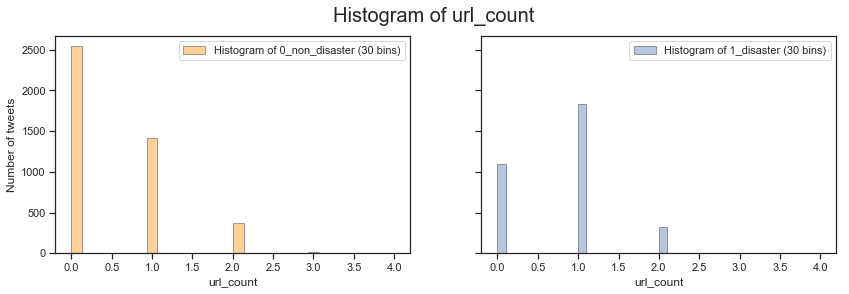

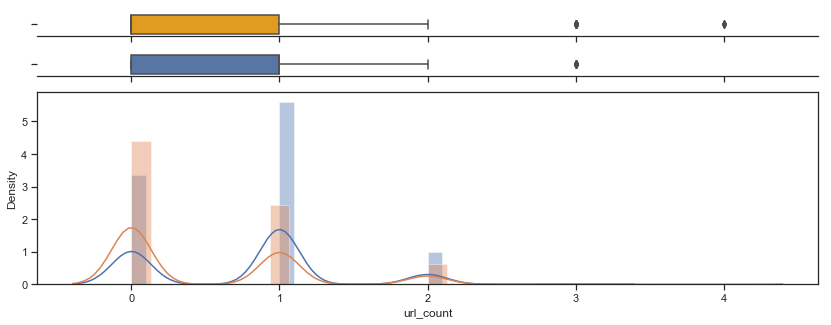

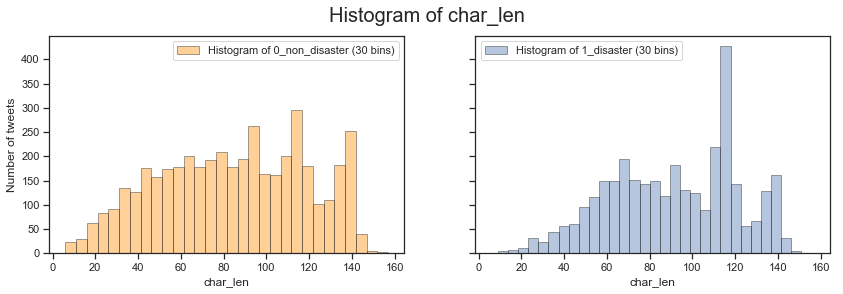

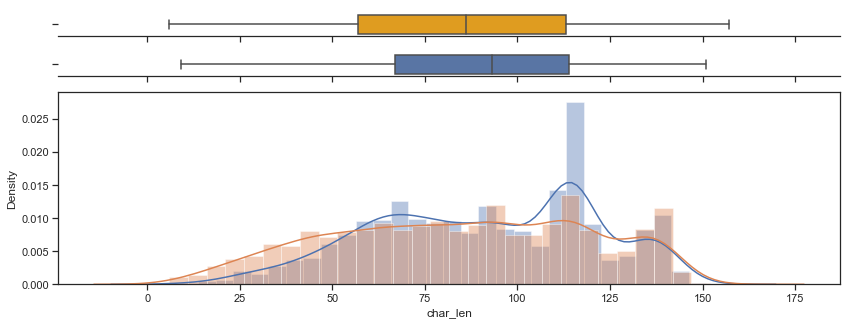

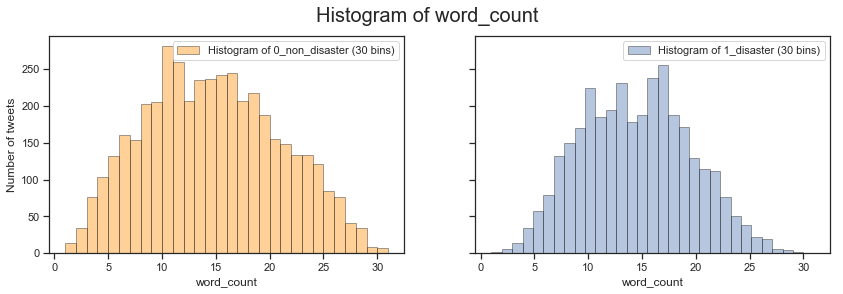

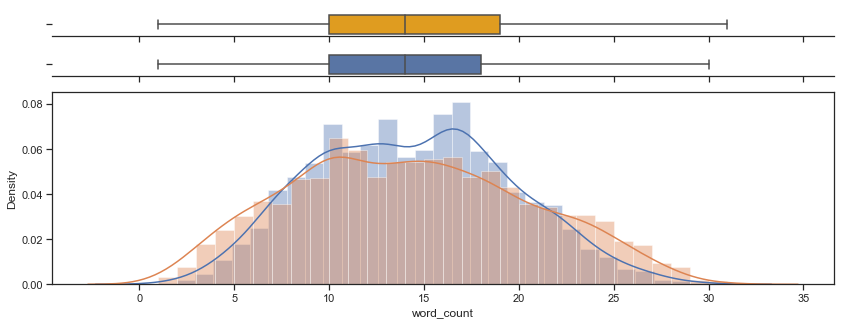

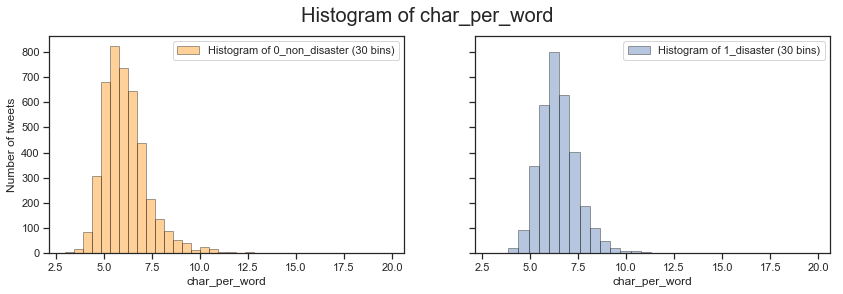

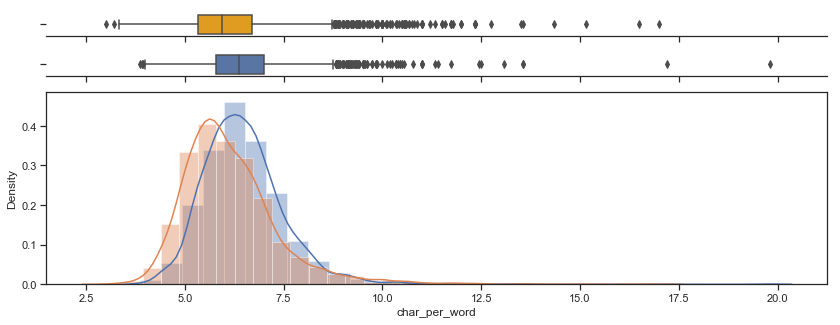

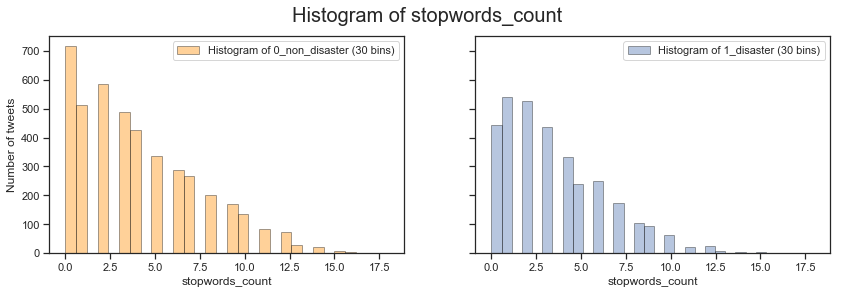

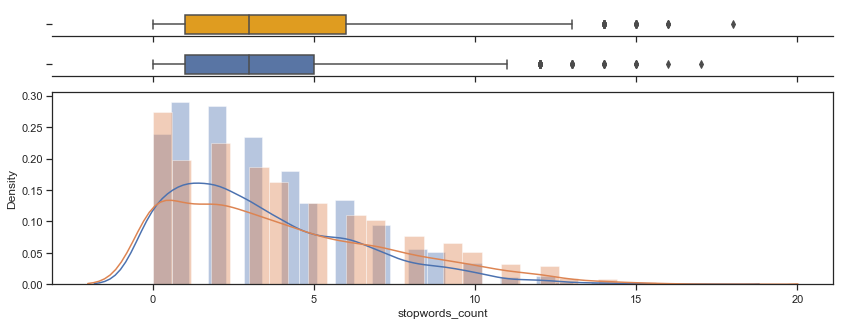

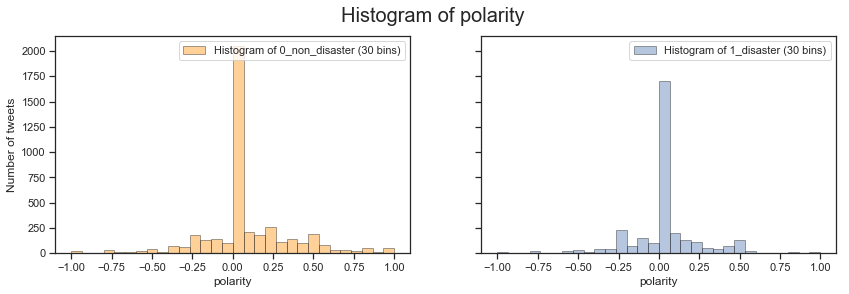

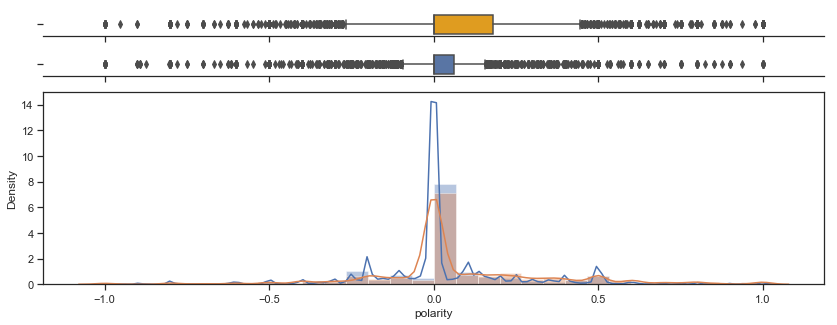

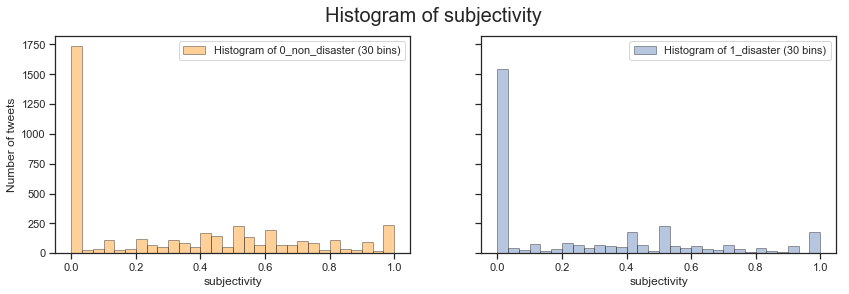

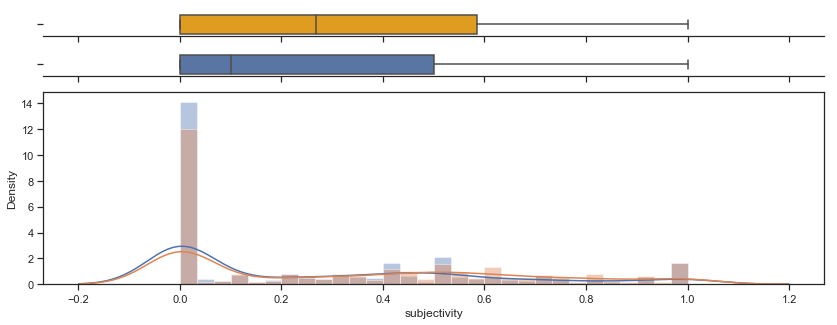

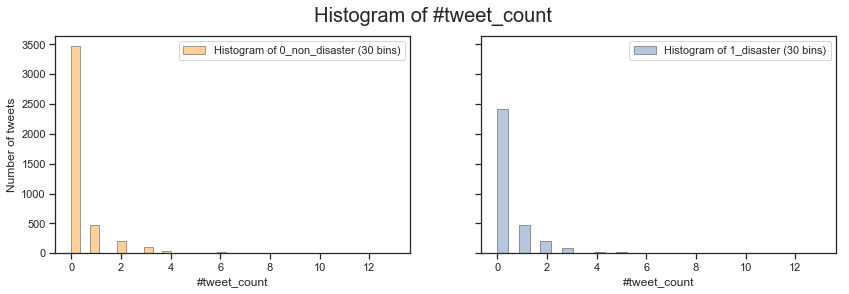

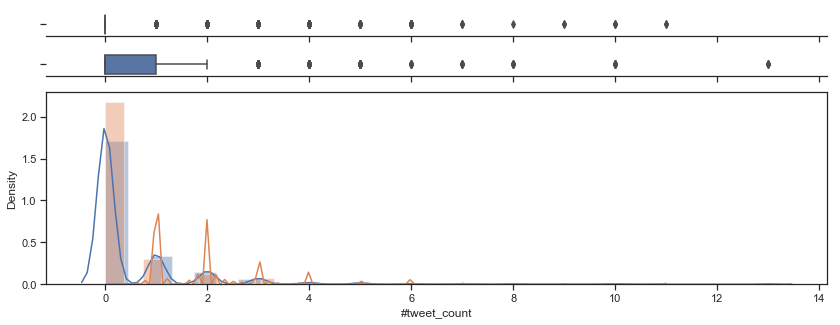

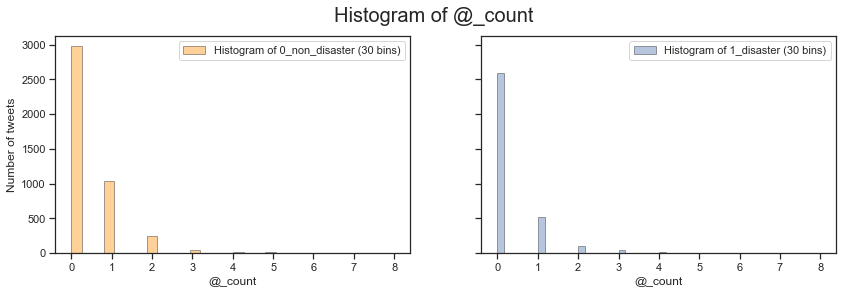

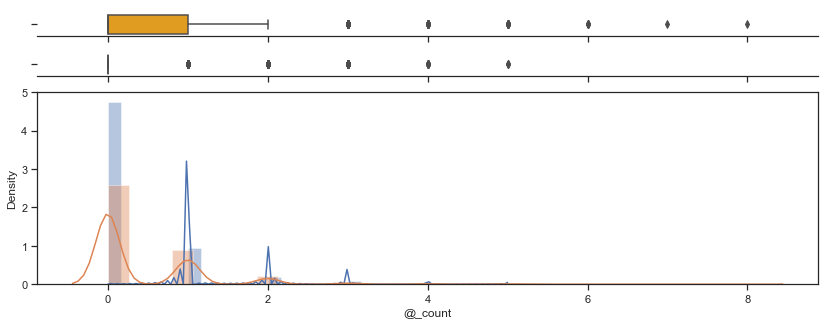

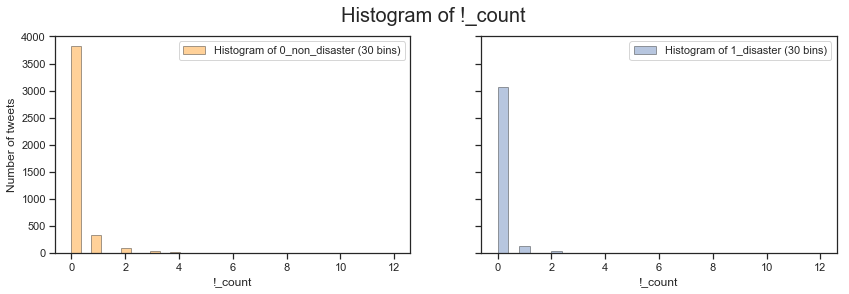

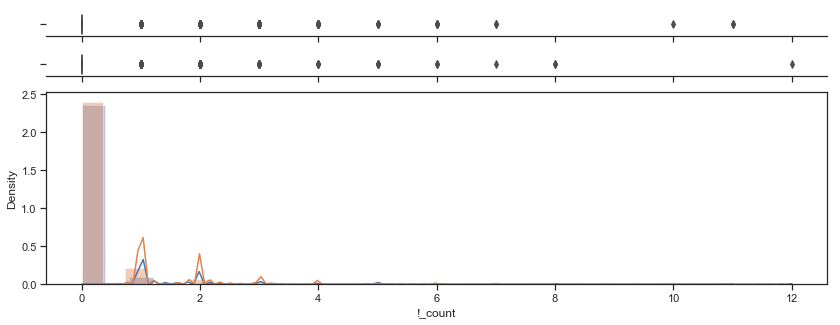

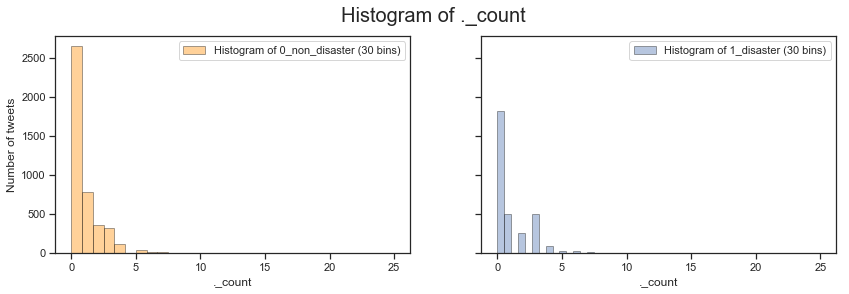

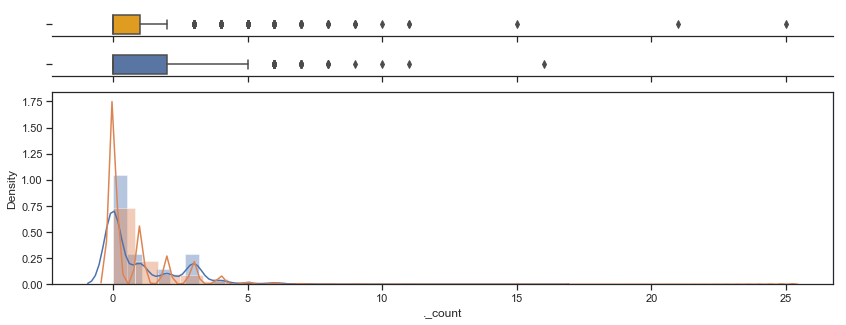

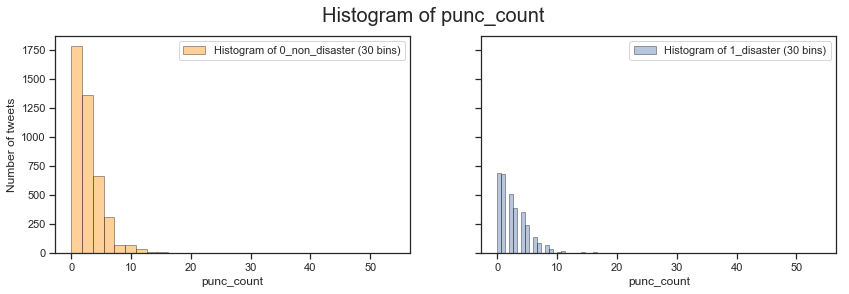

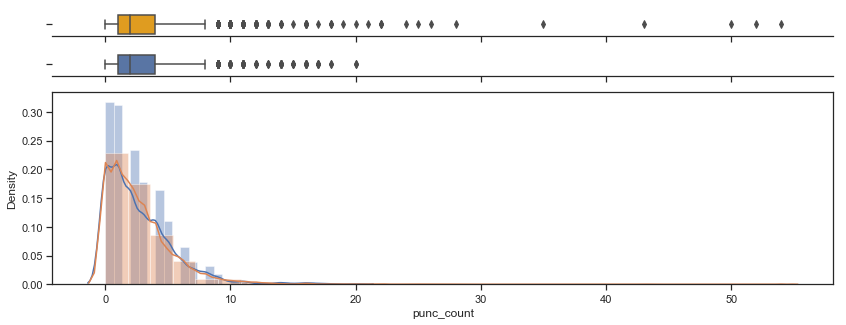

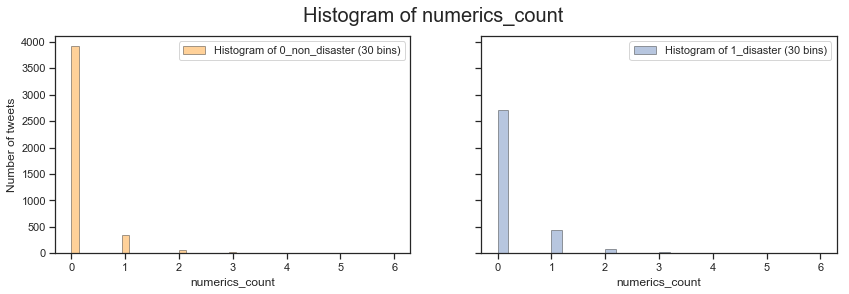

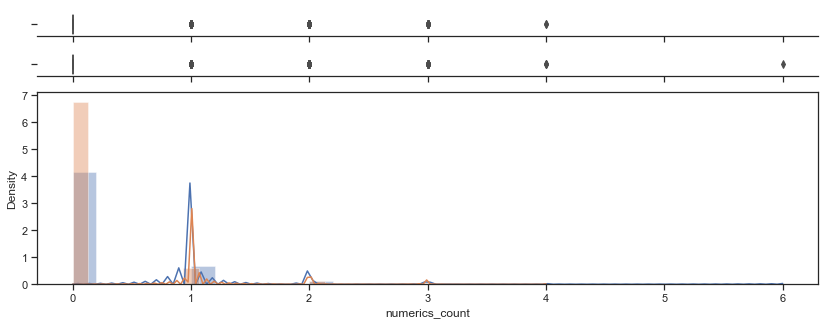

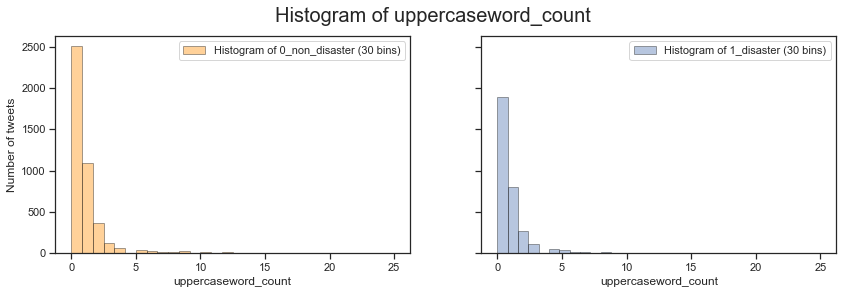

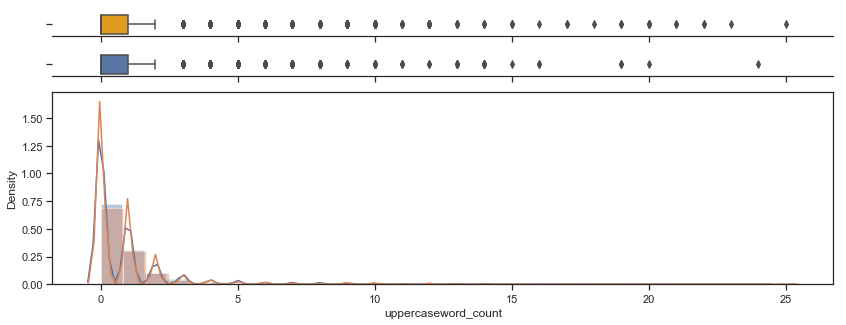

In [467]:
feature_names = ['url_count','char_len','word_count', 'char_per_word', 'stopwords_count', 'polarity', 'subjectivity','#tweet_count', '@_count', '!_count','._count', 'punc_count', 'numerics_count', 'uppercaseword_count']
for i in feature_names:
    plot_univariate(i)

In [468]:
len(feature_names)

14

In [469]:
combinations = [[a, b] for a in feature_names for b in feature_names if a != b] 
def plotpairs(x):
    temp = []
    for i in x:
        if i not in temp and [i[1],i[0]] not in temp:
            temp.append(i)
    return temp
bivariate_plotpairs = plotpairs(combinations)
print(bivariate_plotpairs)

[['url_count', 'char_len'], ['url_count', 'word_count'], ['url_count', 'char_per_word'], ['url_count', 'stopwords_count'], ['url_count', 'polarity'], ['url_count', 'subjectivity'], ['url_count', '#tweet_count'], ['url_count', '@_count'], ['url_count', '!_count'], ['url_count', '._count'], ['url_count', 'punc_count'], ['url_count', 'numerics_count'], ['url_count', 'uppercaseword_count'], ['char_len', 'word_count'], ['char_len', 'char_per_word'], ['char_len', 'stopwords_count'], ['char_len', 'polarity'], ['char_len', 'subjectivity'], ['char_len', '#tweet_count'], ['char_len', '@_count'], ['char_len', '!_count'], ['char_len', '._count'], ['char_len', 'punc_count'], ['char_len', 'numerics_count'], ['char_len', 'uppercaseword_count'], ['word_count', 'char_per_word'], ['word_count', 'stopwords_count'], ['word_count', 'polarity'], ['word_count', 'subjectivity'], ['word_count', '#tweet_count'], ['word_count', '@_count'], ['word_count', '!_count'], ['word_count', '._count'], ['word_count', 'pun

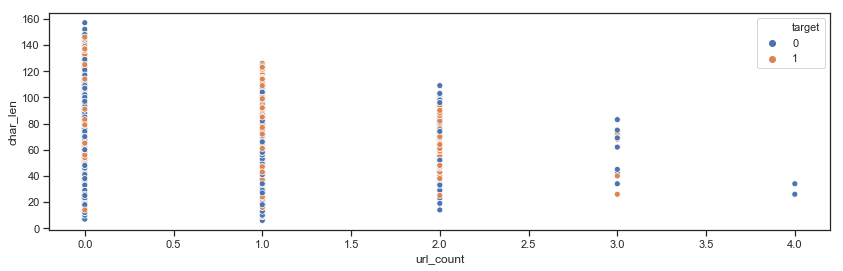

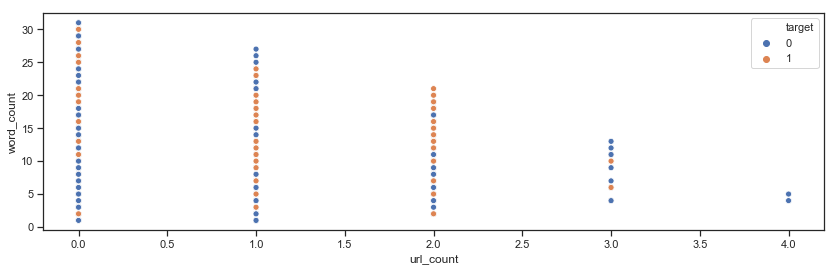

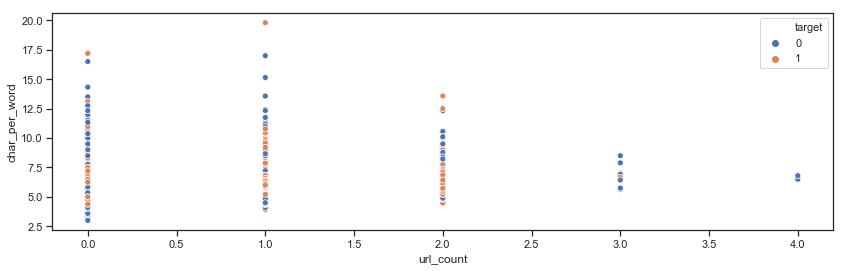

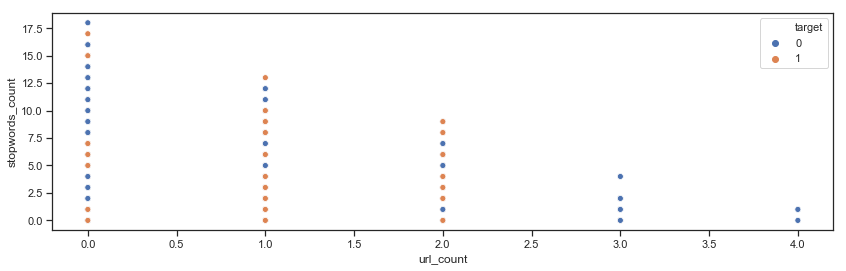

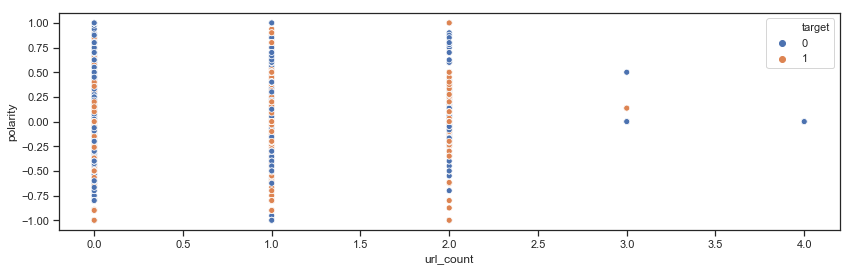

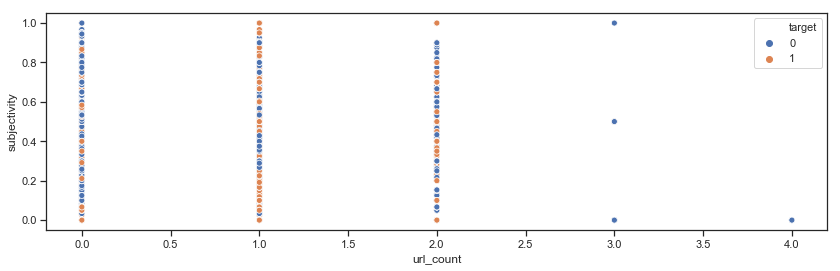

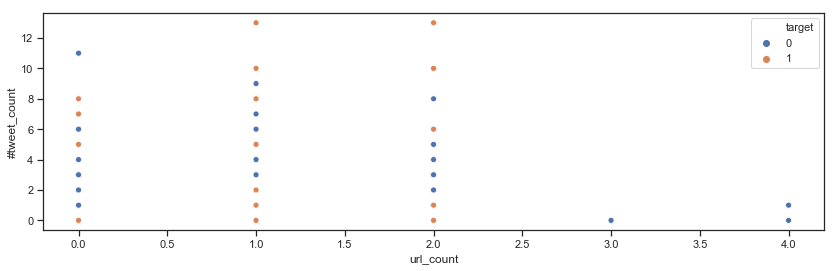

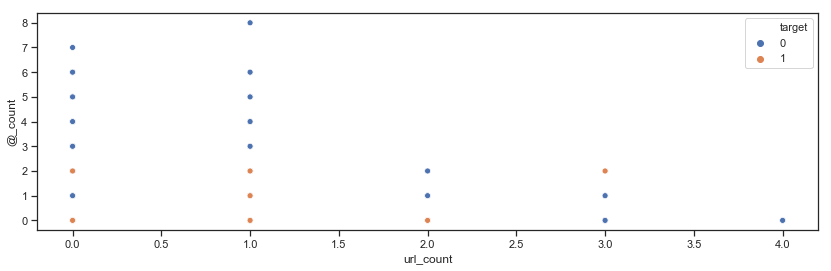

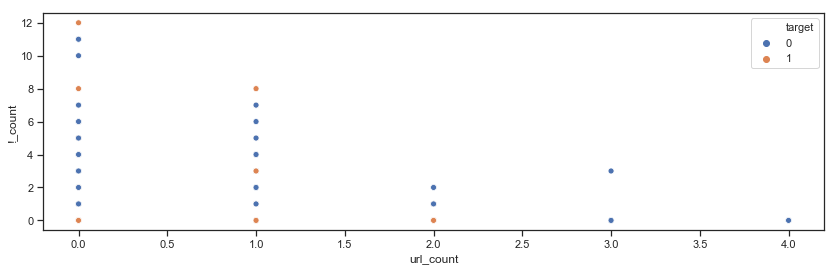

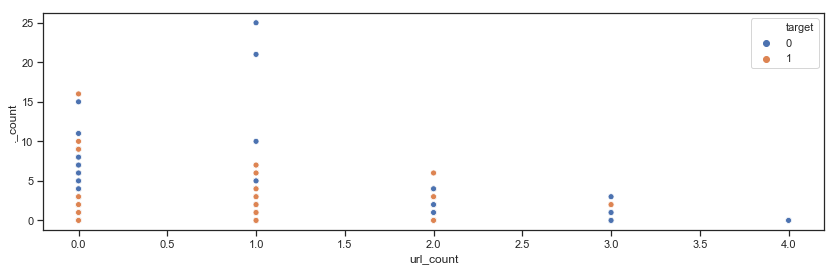

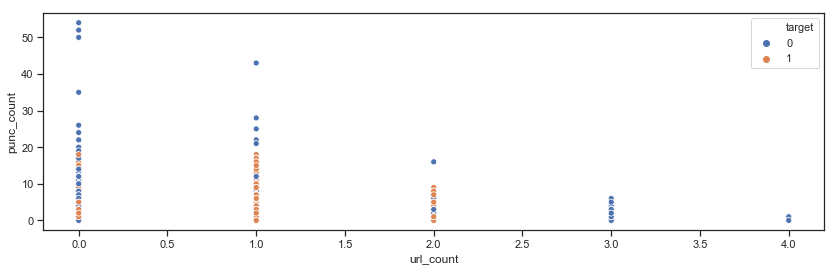

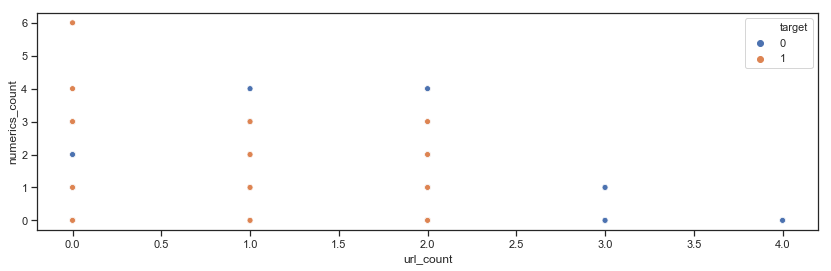

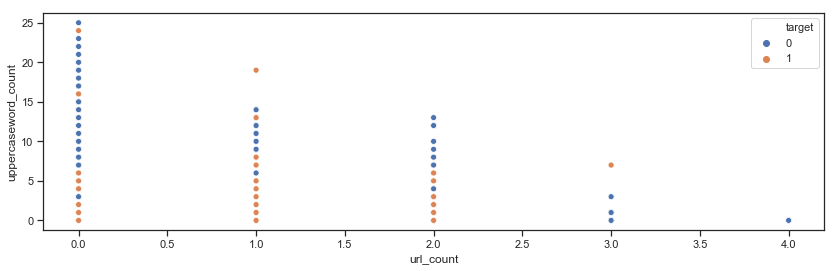

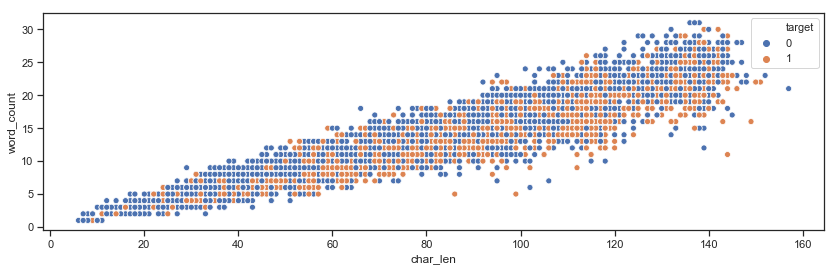

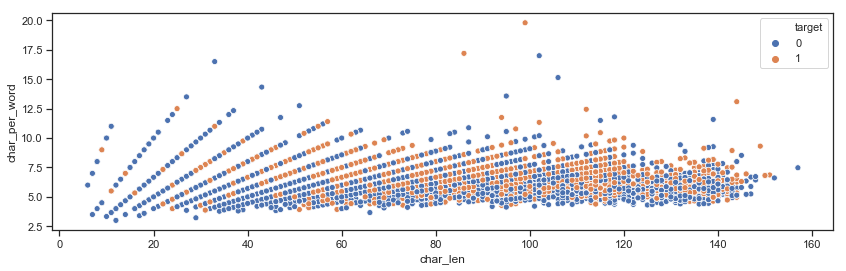

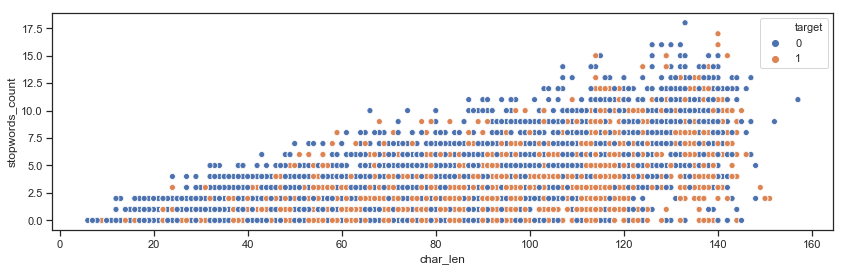

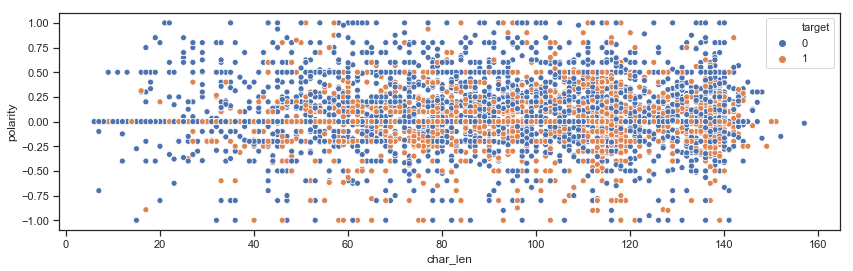

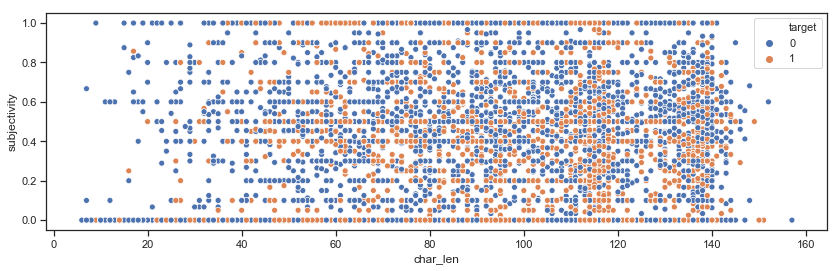

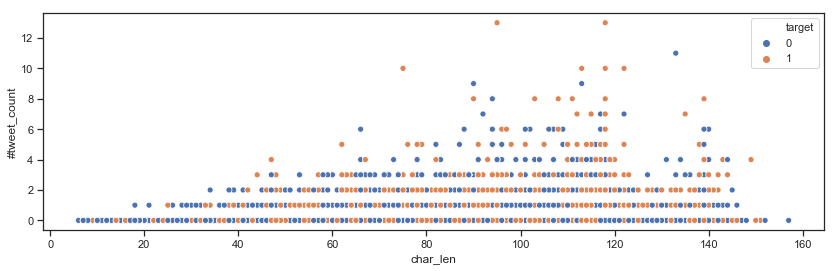

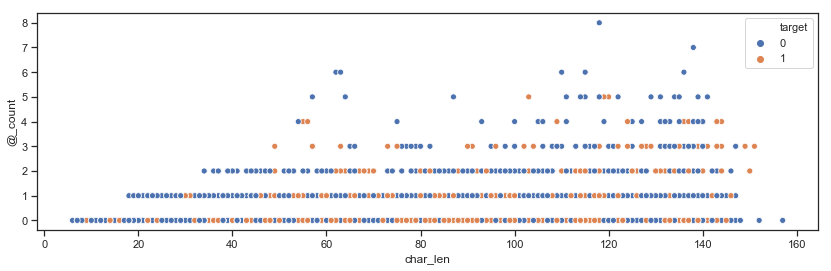

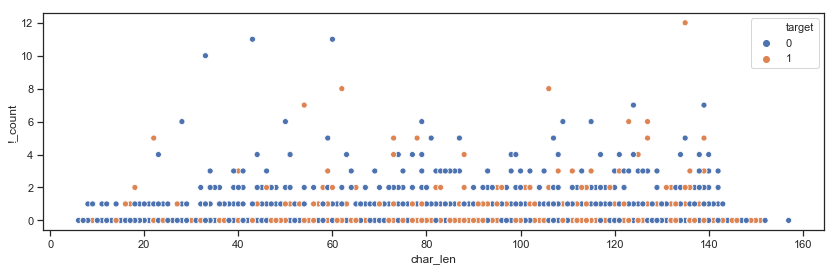

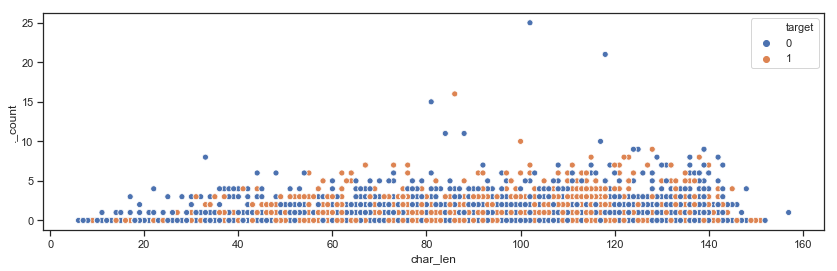

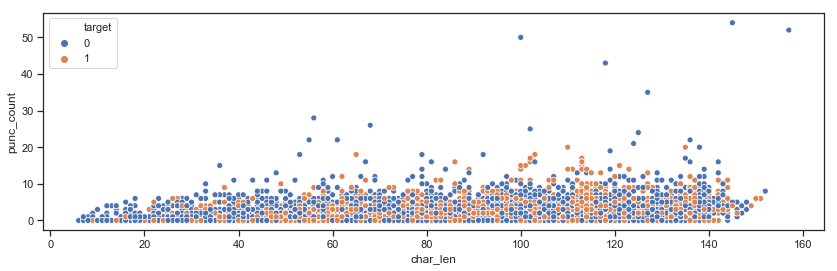

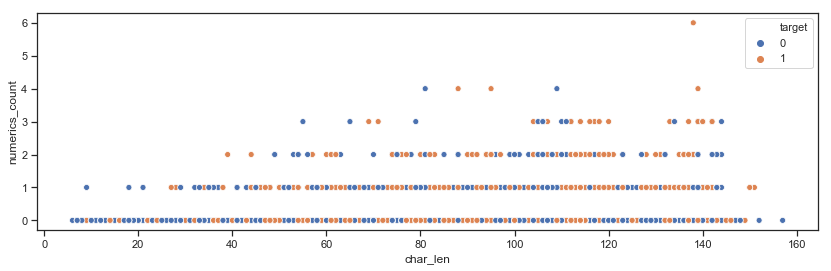

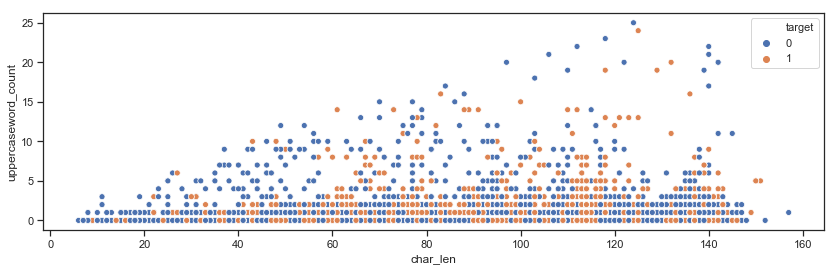

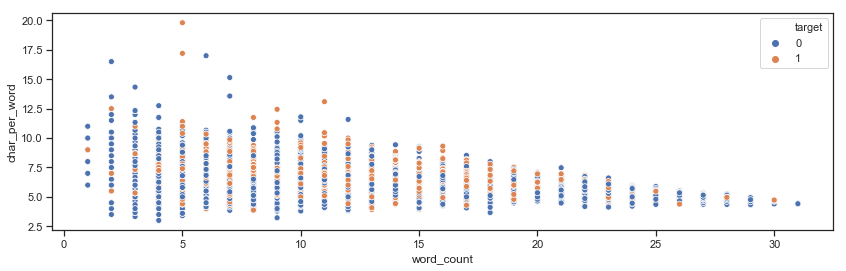

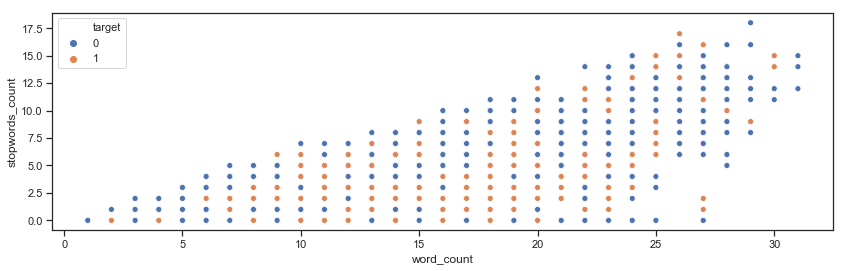

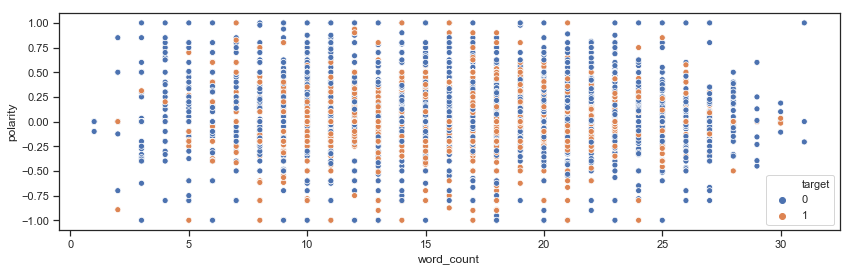

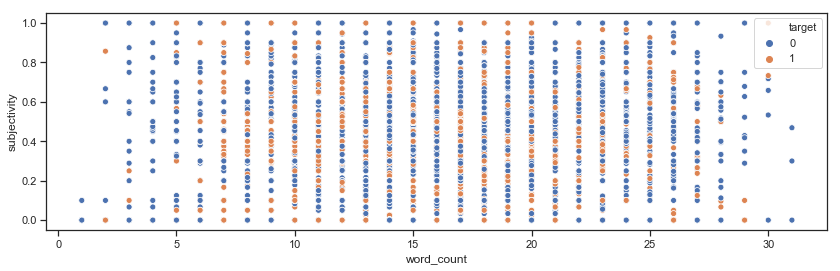

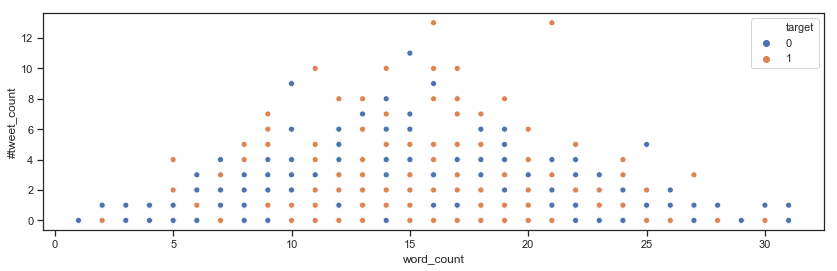

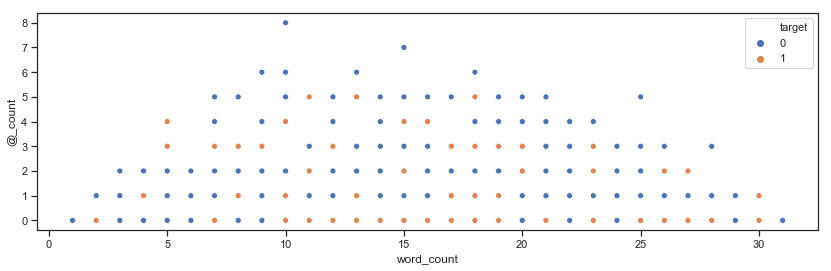

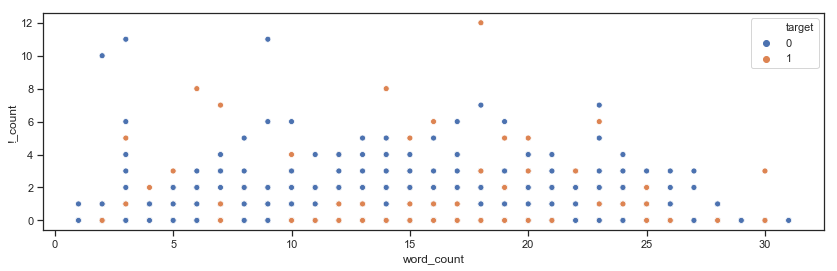

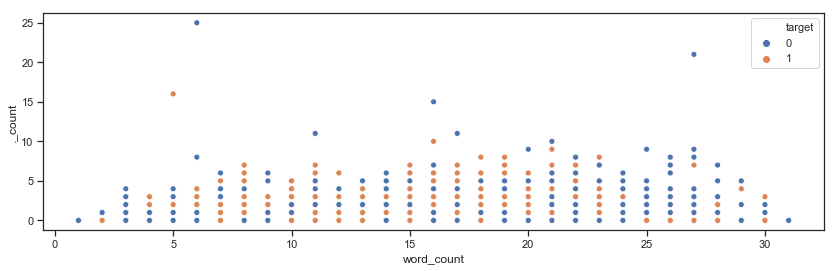

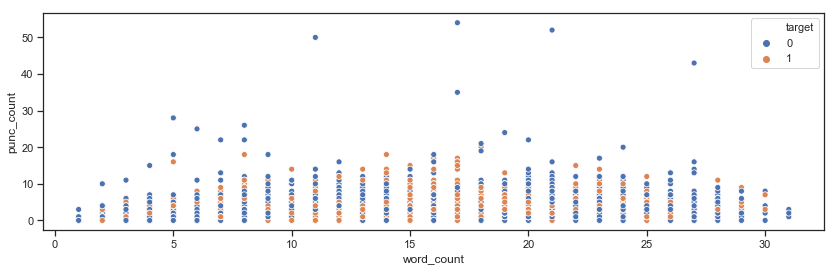

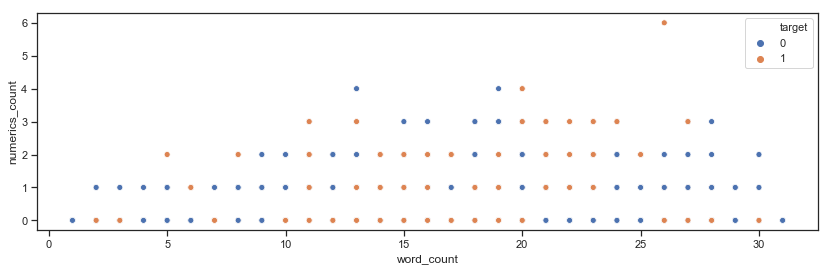

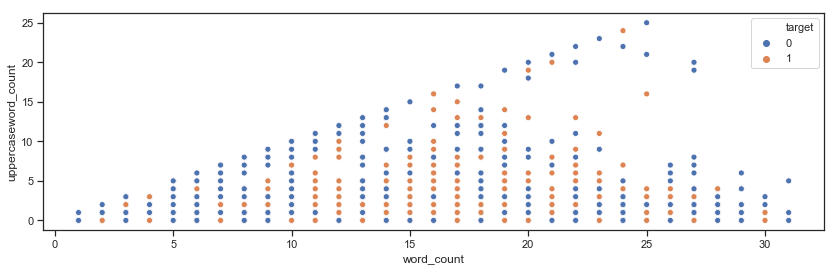

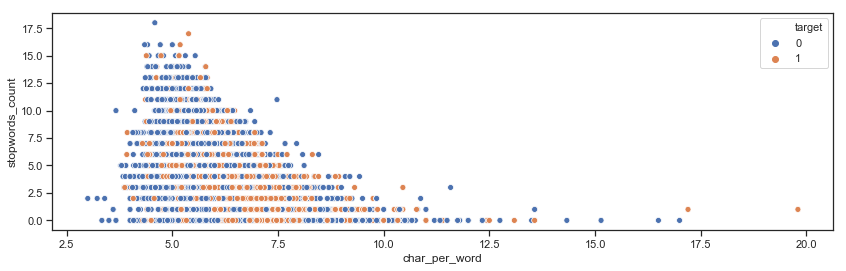

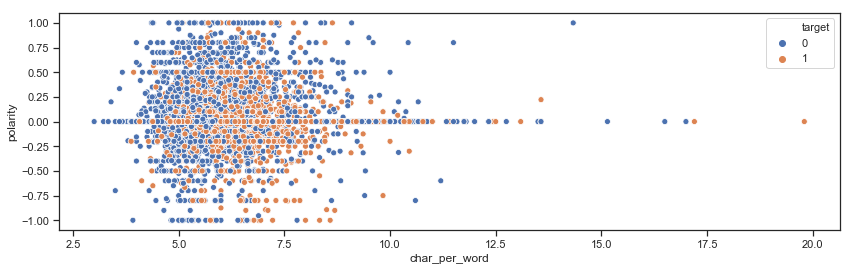

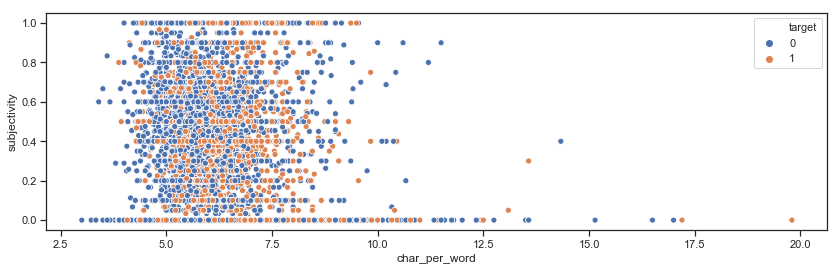

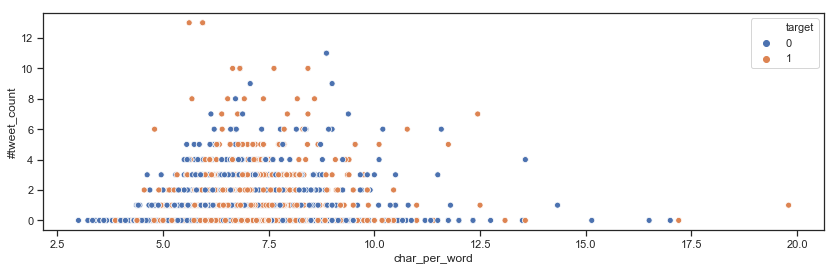

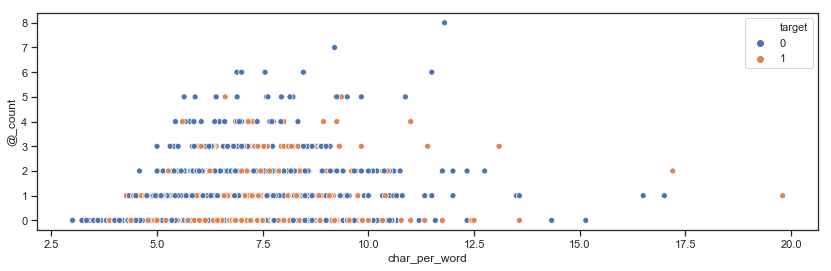

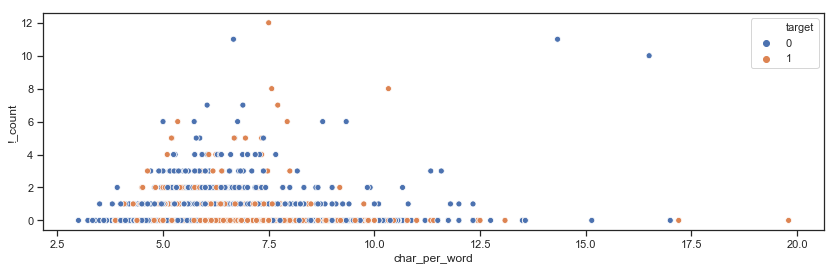

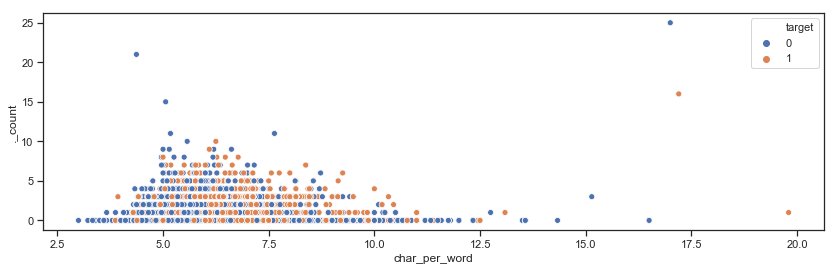

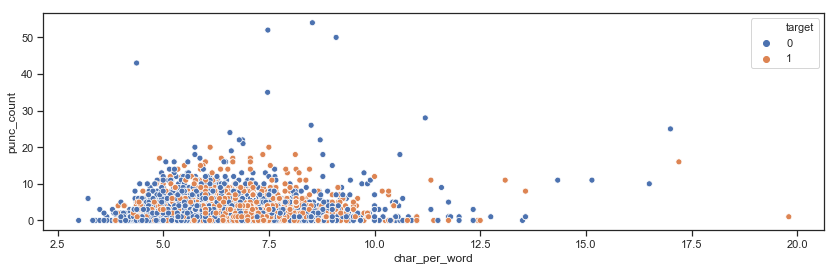

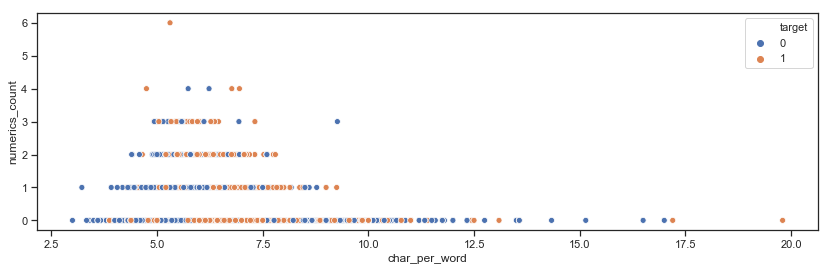

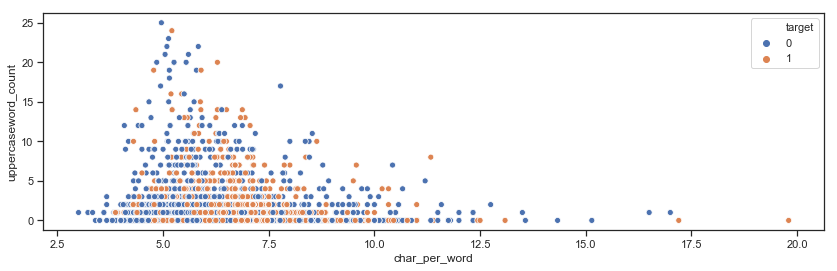

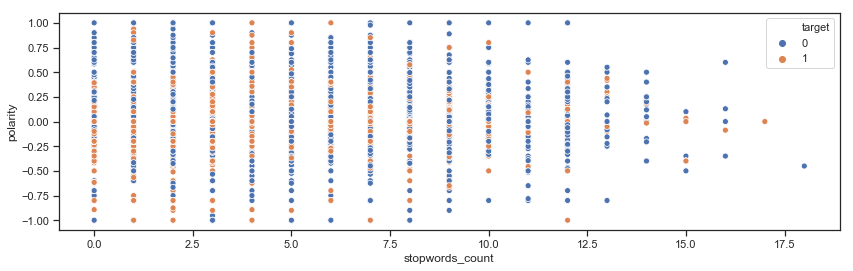

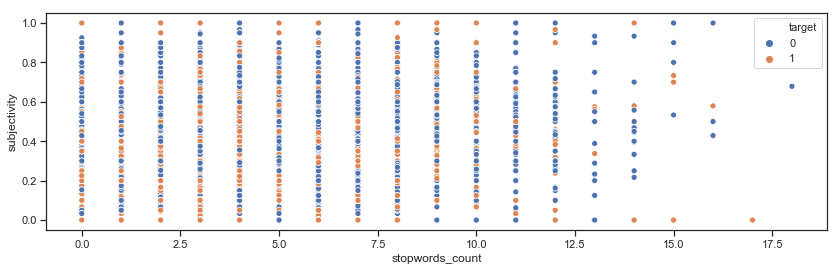

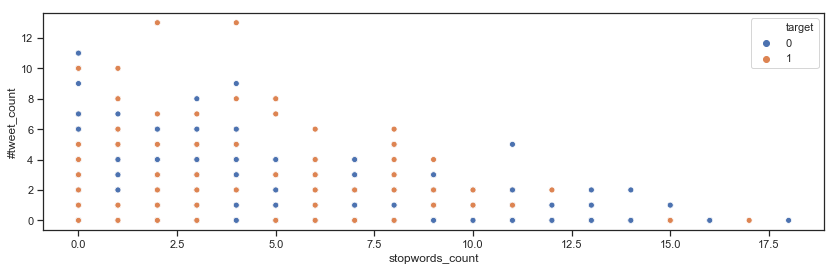

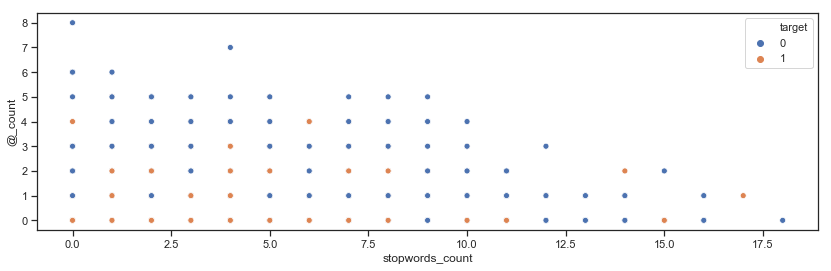

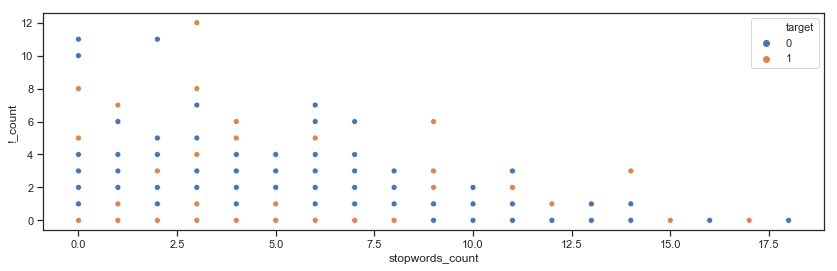

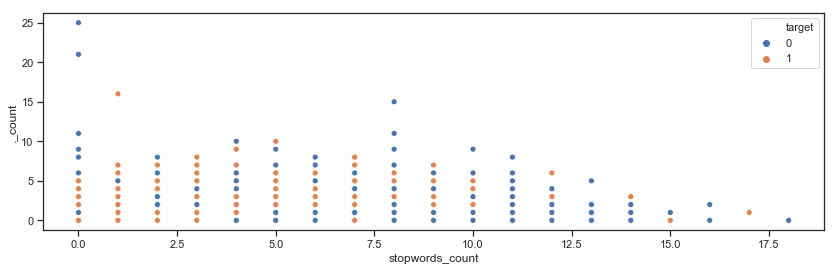

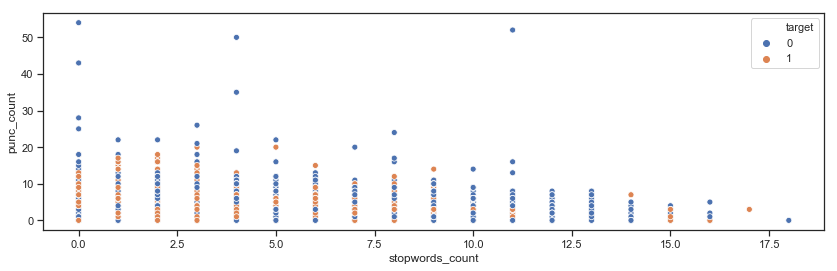

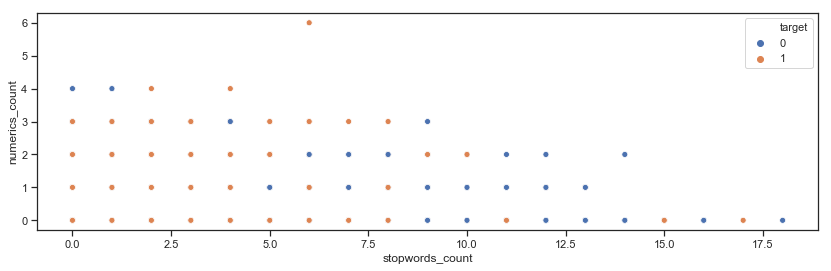

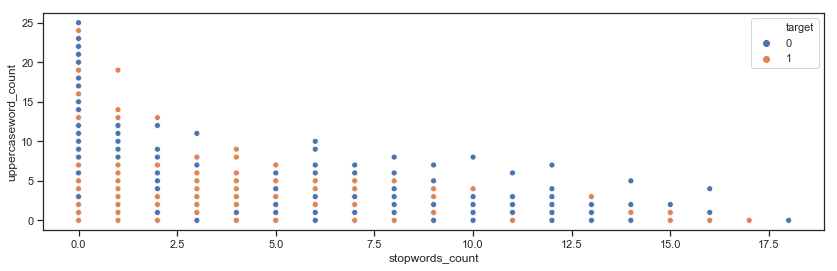

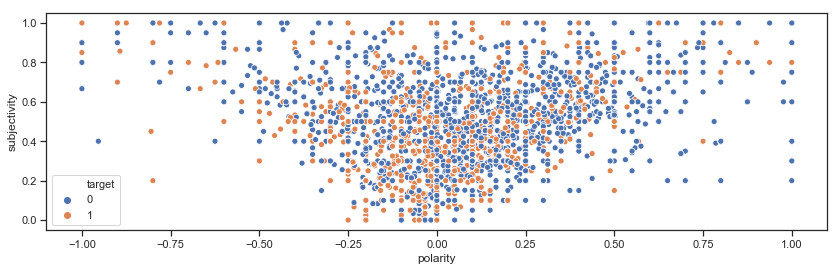

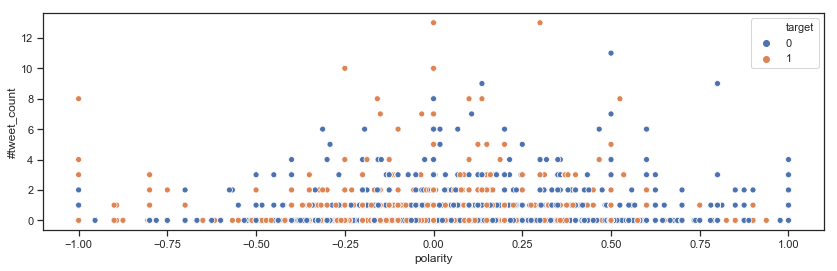

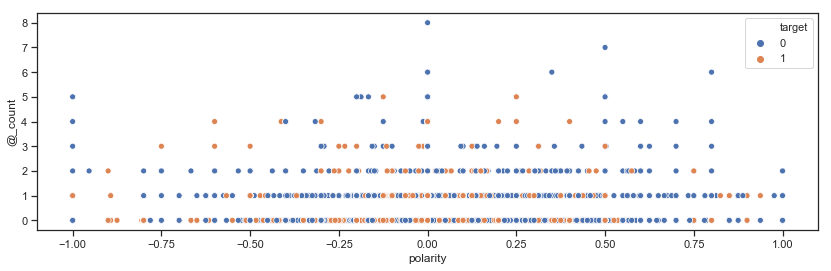

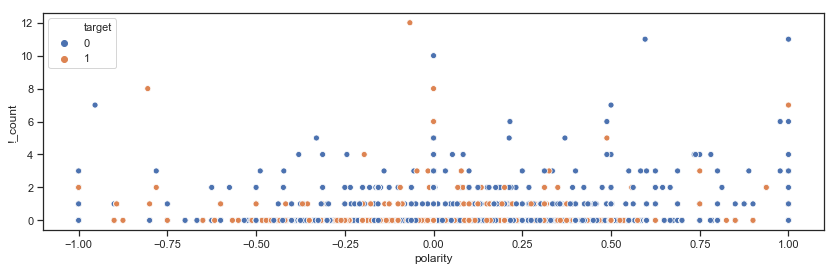

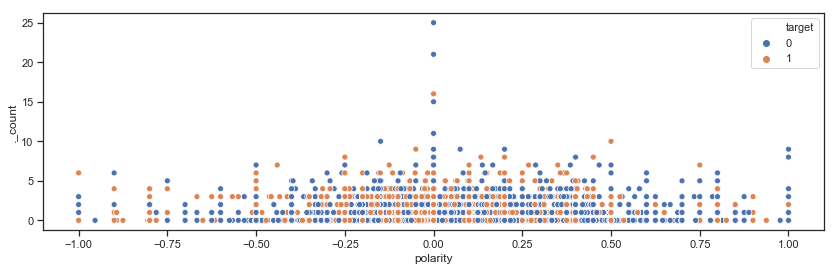

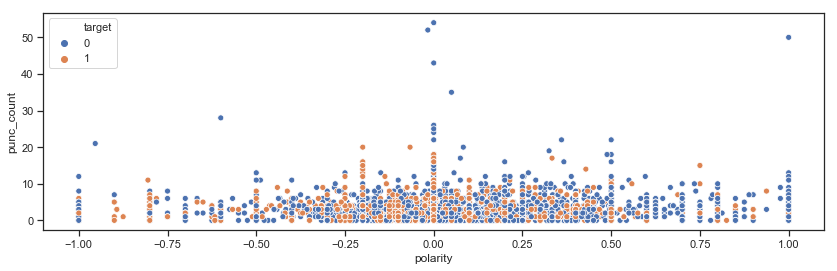

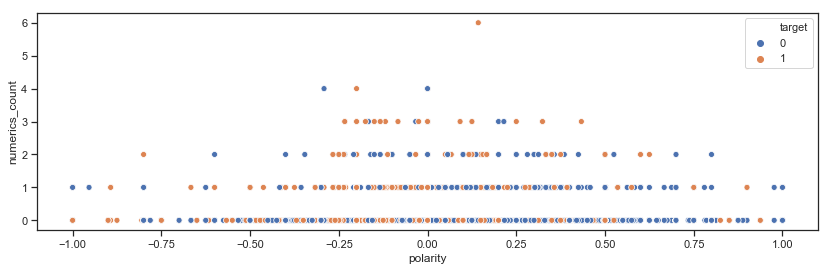

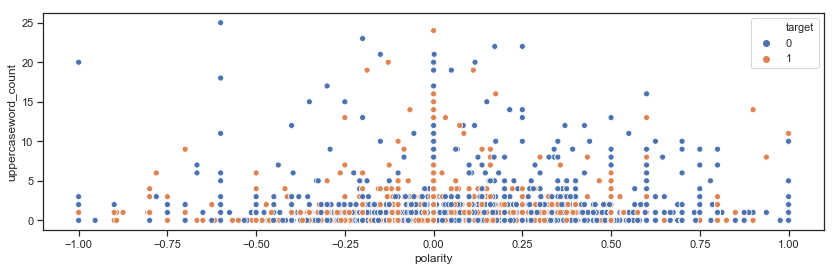

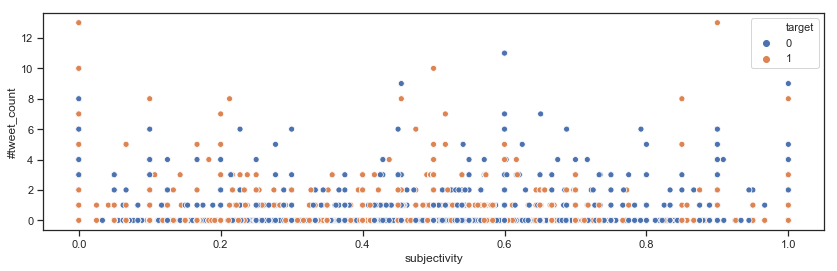

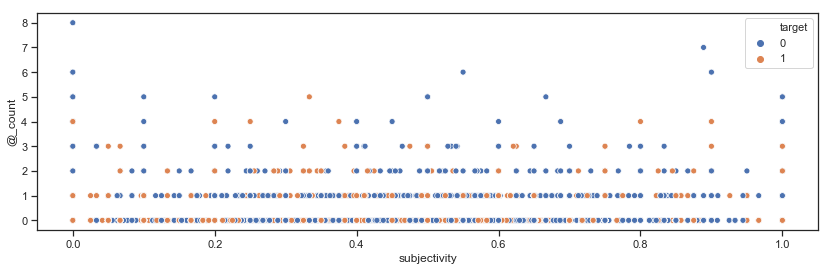

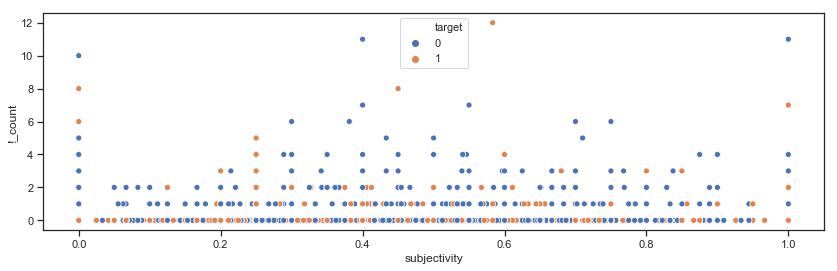

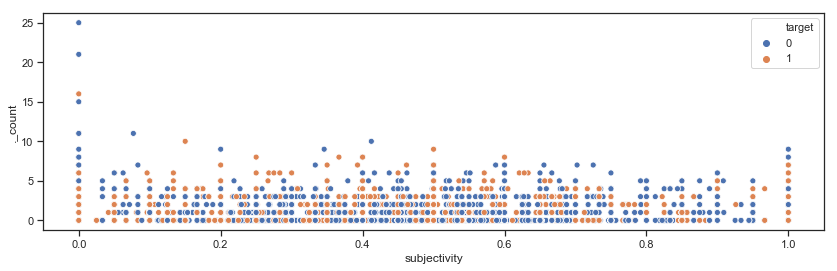

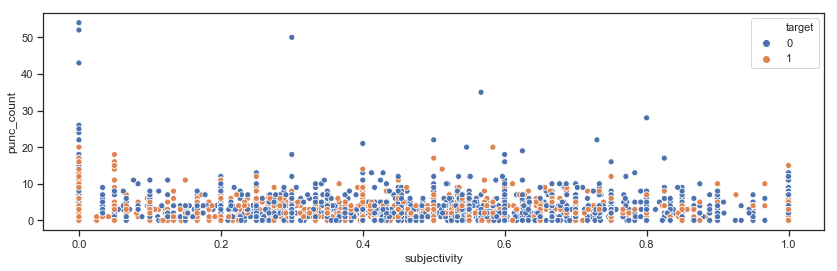

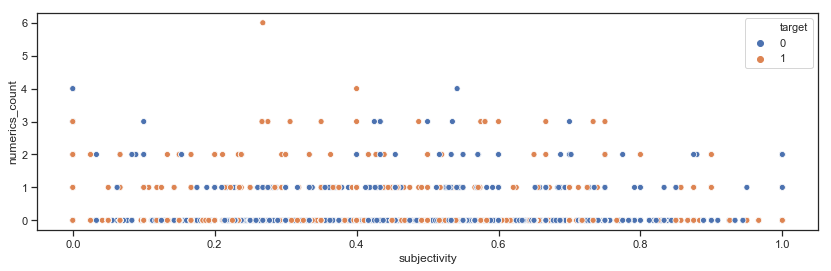

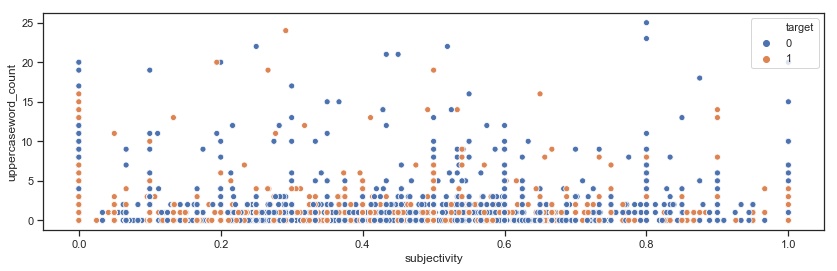

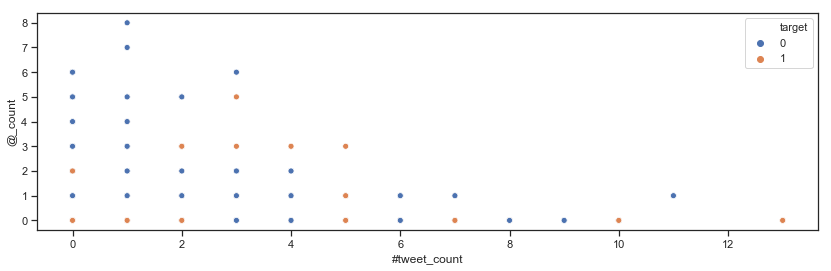

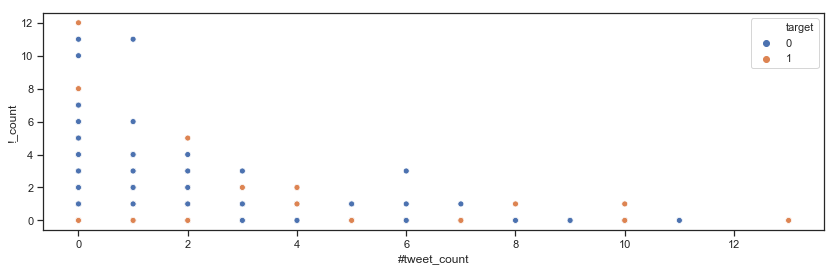

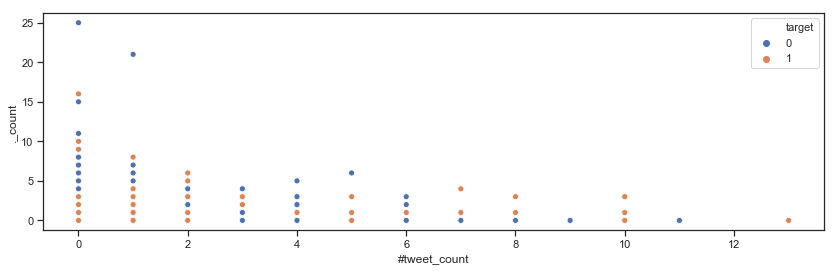

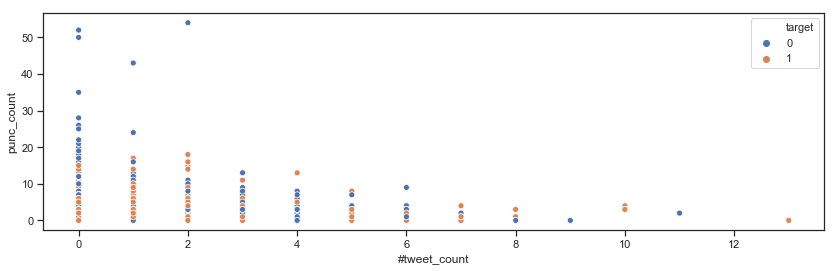

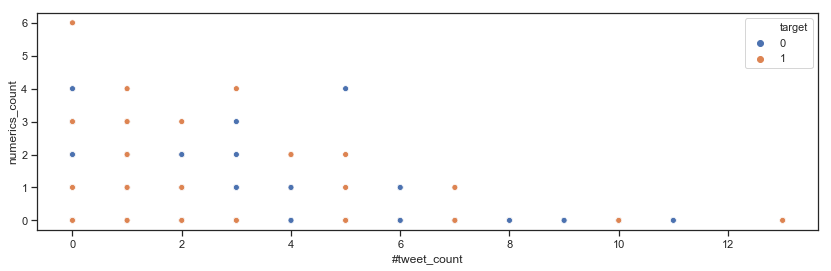

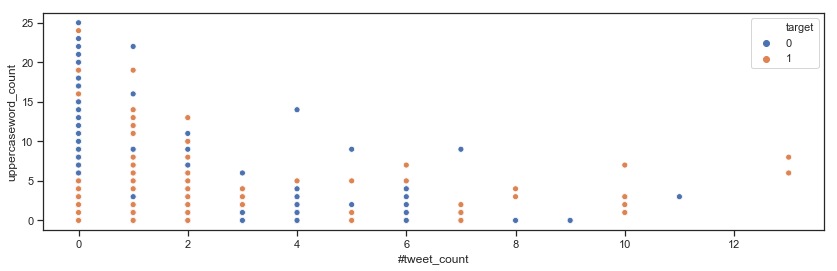

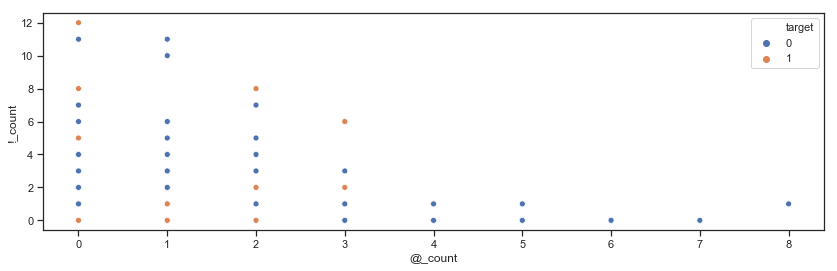

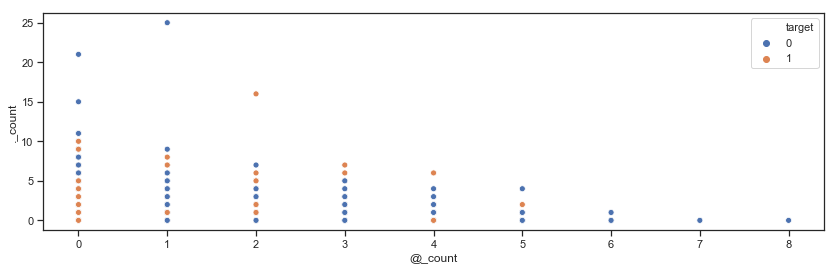

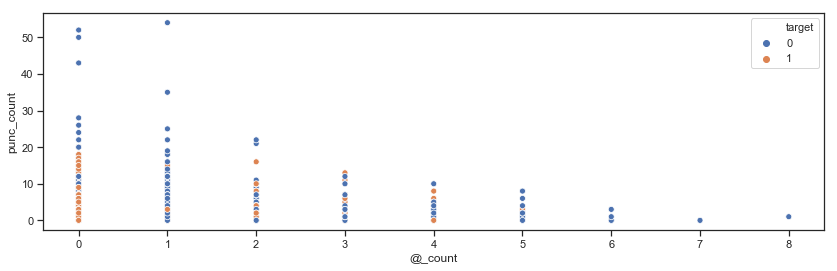

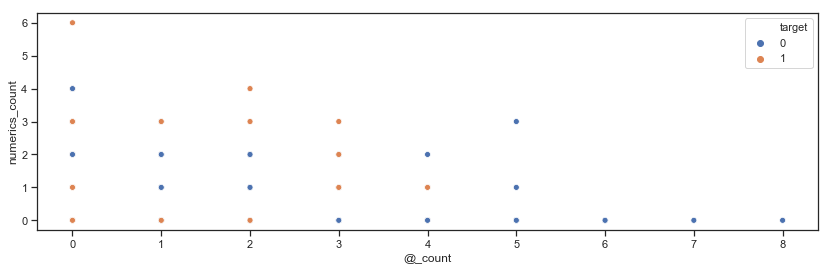

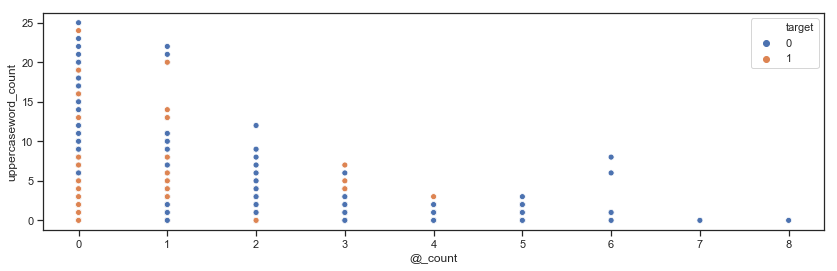

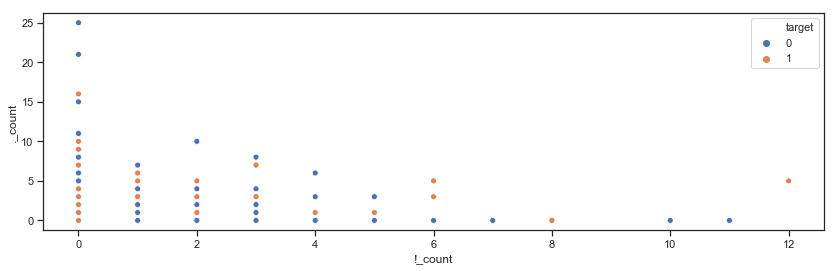

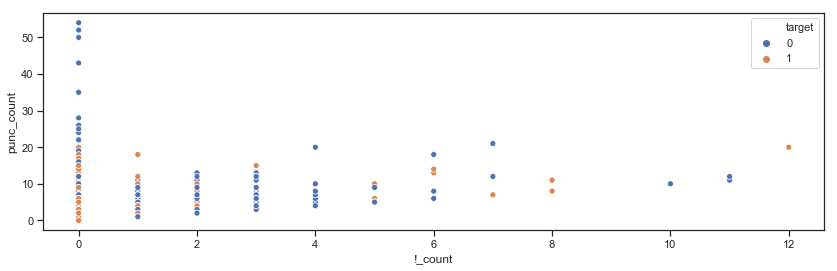

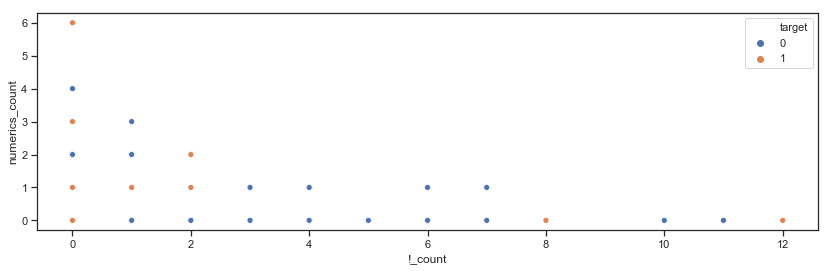

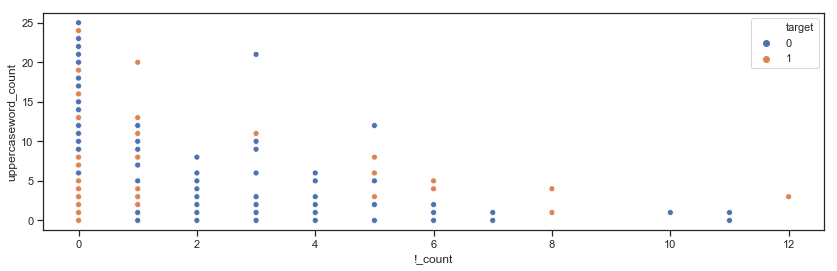

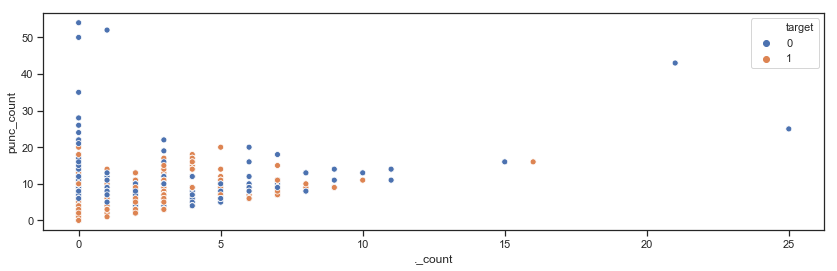

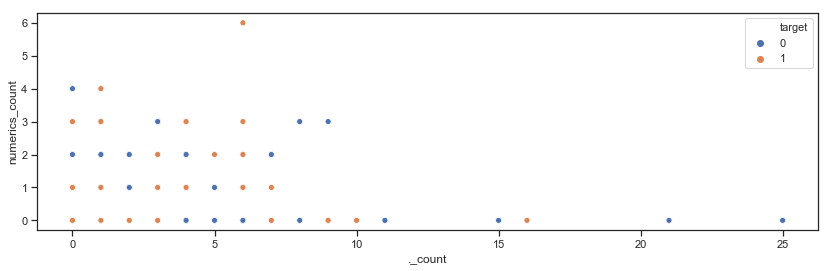

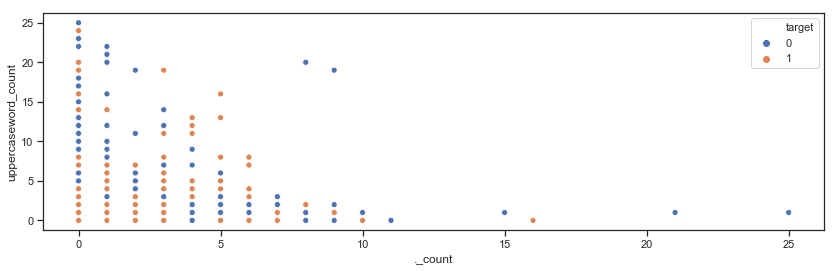

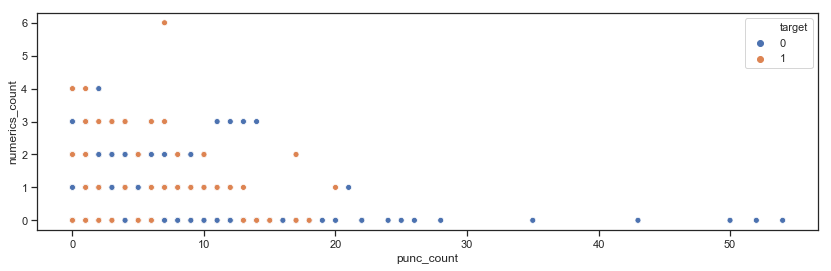

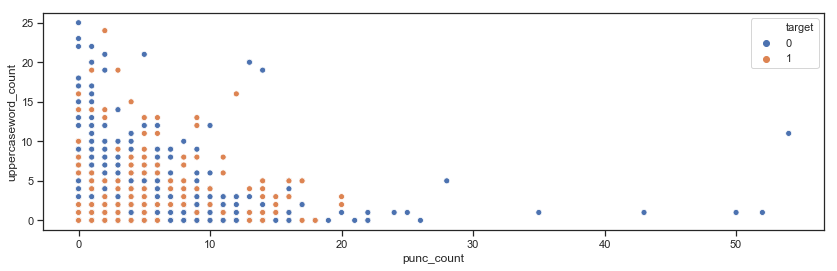

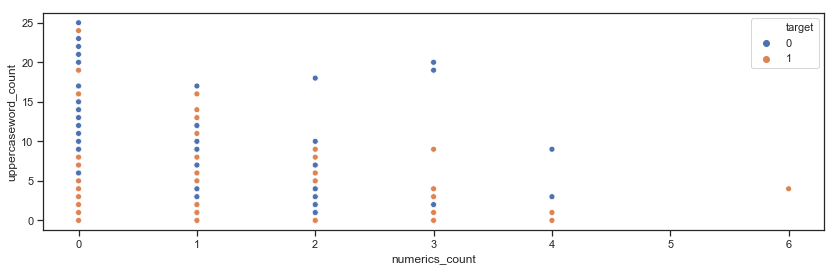

In [470]:
#91 plots (14 features X 14 / 2 - 14)
def plot_bivariate(the_list):
    for (x,y) in the_list:
        f, axes = plt.subplots(1,1, figsize=(14,4))
        sns.scatterplot(x=x, y=y, hue='target', data=df_new)
plot_bivariate(bivariate_plotpairs)

In [485]:
feature_names = ['url_count','char_len','word_count', 'char_per_word', 'stopwords_count', 'polarity', 'subjectivity','#tweet_count', '@_count', '!_count','._count', 'punc_count', 'numerics_count', 'uppercaseword_count']
df_new[feature_names].corr()

url_count  char_len  word_count  char_per_word  \
url_count             1.000000 -0.142362   -0.233699       0.224279   
char_len             -0.142362  1.000000    0.920872      -0.031371   
word_count           -0.233699  0.920872    1.000000      -0.367363   
char_per_word         0.224279 -0.031371   -0.367363       1.000000   
stopwords_count      -0.396191  0.601275    0.757053      -0.436269   
polarity              0.027904  0.023469    0.030384      -0.028816   
subjectivity         -0.103907  0.187056    0.227330      -0.147008   
#tweet_count          0.173112  0.137052    0.023285       0.214342   
@_count              -0.221452  0.161434    0.067682       0.205426   
!_count              -0.065428  0.050596    0.041895       0.044301   
._count              -0.076188  0.338116    0.302222       0.014412   
punc_count           -0.080309  0.323413    0.267958       0.064991   
numerics_count        0.074952  0.134936    0.151177      -0.076524   
uppercaseword_count   0.016824  0.110705    0.139995      -0.087132   

                     stopwords_count  polarity  subjectivity  #tweet_count  \
url_count                  -0.396191  0.027904     -0.103907      0.173112   
char_len                    0.601275  0.023469      0.187056      0.137052   
word_count                  0.757053  0.030384      0.227330      0.023285   
char_per_word              -0.436269 -0.028816     -0.147008      0.214342   
stopwords_count             1.000000  0.011612      0.196072     -0.110889   
polarity                    0.011612  1.000000      0.195180      0.025920   
subjectivity                0.196072  0.195180      1.000000     -0.038152   
#tweet_count               -0.110889  0.025920     -0.038152      1.000000   
@_count                     0.066728  0.031236      0.026696     -0.043339   
!_count                     0.028139  0.072067      0.055745      0.005698   
._count                     0.168557  0.003608      0.064527     -0.024242   
punc_count                  0.098504  0.039796      0.051635     -0.018858   
numerics_count             -0.037443 -0.007785     -0.023850      0.016812   
uppercaseword_count        -0.131898  0.045735      0.035335      0.053894   

                      @_count   !_count   ._count  punc_count  numerics_count  \
url_count           -0.221452 -0.065428 -0.076188   -0.080309        0.074952   
char_len             0.161434  0.050596  0.338116    0.323413        0.134936   
word_count           0.067682  0.041895  0.302222    0.267958        0.151177   
char_per_word        0.205426  0.044301  0.014412    0.064991       -0.076524   
stopwords_count      0.066728  0.028139  0.168557    0.098504       -0.037443   
polarity             0.031236  0.072067  0.003608    0.039796       -0.007785   
subjectivity         0.026696  0.055745  0.064527    0.051635       -0.023850   
#tweet_count        -0.043339  0.005698 -0.024242   -0.018858        0.016812   
@_count              1.000000  0.069597 -0.012961    0.003530       -0.033054   
!_count              0.069597  1.000000 -0.032391    0.215243       -0.027095   
._count             -0.012961 -0.032391  1.000000    0.559804        0.059354   
punc_count           0.003530  0.215243  0.559804    1.000000        0.032155   
numerics_count      -0.033054 -0.027095  0.059354    0.032155        1.000000   
uppercaseword_count  0.011541  0.064380  0.038744    0.095793        0.083182   

                     uppercaseword_count  
url_count                       0.016824  
char_len                        0.110705  
word_count                      0.139995  
char_per_word                  -0.087132  
stopwords_count                -0.131898  
polarity                        0.045735  
subjectivity                    0.035335  
#tweet_count                    0.053894  
@_count                         0.011541  
!_count                         0.064380  
._count                         0.038744  
punc_count                      0.095793  
numerics_

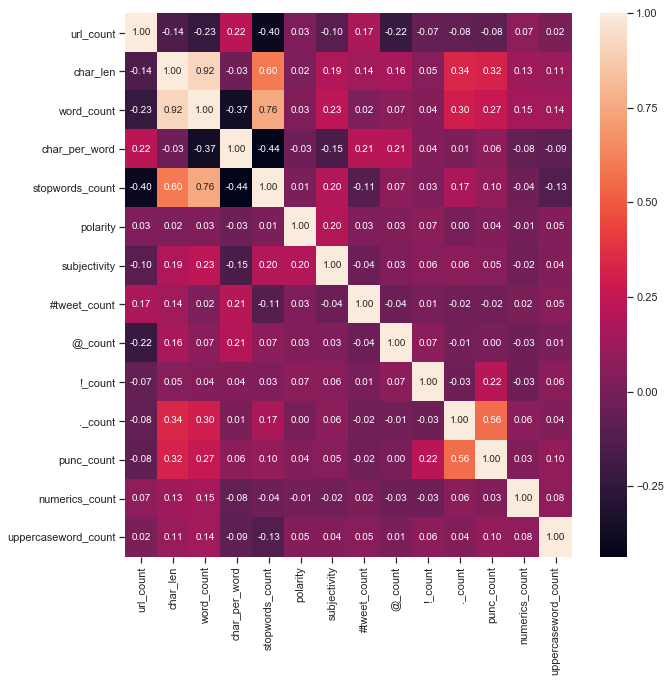

In [486]:
fig, axes = plt.subplots(figsize=(10, 10))
sns.heatmap(df_new[feature_names].corr(), ax=axes, annot=True, fmt='.2f')

In [487]:
wordcloud_0_non_disaster = []
for tweet in df_new[df_new['target'] == 0]['text_nourl_lowercase_nopunc']:
    wordcloud_0_non_disaster.append(word_tokenize(tweet))

wordcloud_1_disaster = []
for tweet in df_new[df_new['target'] == 1]['text_nourl_lowercase_nopunc']:
    wordcloud_1_disaster.append(word_tokenize(tweet))

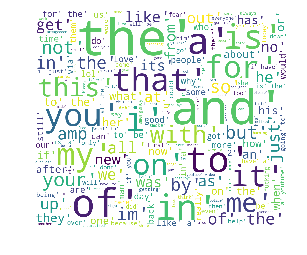

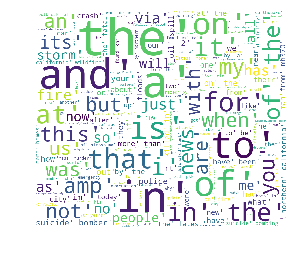

In [488]:
#There are a lot of stop words. We will remove stop words and run 
wordcloud = WordCloud(background_color='white',max_words=200,max_font_size=200,width=1000, height=860, random_state=42).generate(str(wordcloud_0_non_disaster))
fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

wordcloud = WordCloud(background_color='white',max_words=200,max_font_size=200,width=1000, height=860, random_state=42).generate(str(wordcloud_1_disaster))
fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [489]:
#Something went wrong here

class PlainTokenizer_leavestop(object):
    def __init__(self):
        self.stemmer = SnowballStemmer(language='english')
    def __call__(self, doc):
        tokens = word_tokenize(doc)
        return [self.stemmer.stem(t) for t in tokens]

class StemmerTokenizer_leavestop(object):
    def __init__(self):
        self.stemmer = SnowballStemmer(language='english')
    def __call__(self, doc):
        tokens = word_tokenize(doc)
        return [self.stemmer.stem(t) for t in tokens]
    
class LemmaTokenizer_leavestop(object):
    def __init__(self):
        self.lemma = WordNetLemmatizer()
    def __call__(self, doc):
        tokens = word_tokenize(doc)
        return [self.lemma.lemmatize(t) for t in tokens]



class PlainTokenizer_removestop(object):
    def __init__(self):
        self.stemmer = SnowballStemmer(language='english')
        self.stop = set(stopwords.words('english'))
    def __call__(self, doc):
        tokens = word_tokenize(doc)
        words = [t for t in words if t not in self.stop]
        return [self.stemmer.stem(t) for t in words]

class StemmerTokenizer_removestop(object):
    def __init__(self):
        self.stemmer = SnowballStemmer(language='english')
        self.stop = set(stopwords.words('english'))
    def __call__(self, doc):
        tokens = word_tokenize(doc)
        words = [t for t in words if t not in self.stop]
        return [self.stemmer.stem(t) for t in words]
    
class LemmaTokenizer_removestop(object):
    def __init__(self):
        self.lemma = WordNetLemmatizer()
        self.stop = set(stopwords.words('english'))
    def __call__(self, doc):
        tokens = word_tokenize(doc)
        words = [t for t in words if t not in self.stop]
        return [self.lemma.lemmatize(t) for t in words]

In [490]:
#Remove stop words | None
#Lemmatizer | Stemmer | None
#Word count | TFIDF
#1 ngram | 1 and 2 ngram

## [Section 5 and 6: Model Engineering and Evaluate Metrics]

# Pipeline 1: logreg + countvect

In [492]:
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline

In [493]:
stemmer = SnowballStemmer(language='english')
lemma = WordNetLemmatizer()
stops = set(stopwords.words('english'))

def stem_tokenize_removestop(document):
    tokens = word_tokenize(document)
    return [stemmer.stem(t) for t in tokens if t.isalpha() and t.lower() not in stops] 

def stem_tokenize_leavestop(document):
    tokens = word_tokenize(document)
    return [stemmer.stem(t) for t in tokens if t.isalpha()] 

def lemm_tokenize_removestop(document):
    tokens = word_tokenize(document)
    return [lemma.lemmatize(t) for t in tokens if t.isalpha() and t.lower() not in stops]

def lemm_tokenize_leavestop(document):
    tokens = word_tokenize(document)
    return [lemma.lemmatize(t) for t in tokens if t.isalpha()]

def tokenize_removestop(document):
    tokens = word_tokenize(document)
    return [t for t in tokens if t.isalpha() and t.lower() not in stops]

def tokenize_leavestop(document):
    tokens = word_tokenize(document)
    return [t for t in tokens if t.isalpha()]

In [521]:
feature_names = ['url_count','char_len','word_count', 'char_per_word', 'stopwords_count', 'polarity', 'subjectivity','#tweet_count', '@_count', '!_count','._count', 'punc_count', 'numerics_count', 'uppercaseword_count']
feature_names.append('text_nourl_lowercase_nopunc')
cols_to_scale = feature_names[0:-1]
cols_to_scale

['url_count',
 'char_len',
 'word_count',
 'char_per_word',
 'stopwords_count',
 'polarity',
 'subjectivity',
 '#tweet_count',
 '@_count',
 '!_count',
 '._count',
 'punc_count',
 'numerics_count',
 'uppercaseword_count']

In [523]:
df_new = df_new.sample(frac = 1) 
X = df_new[feature_names]
y = df_new['target']
X_train, X_test, y_train, y_test = train_test_split(X,y)

In [524]:
X_train.shape

(5709, 15)

In [525]:
#1 pipe per model per vectorizer
#1st combination: logreg + countvect
countvect = CountVectorizer()
ct = make_column_transformer(
    (countvect, 'text_nourl_lowercase_nopunc'),
    (StandardScaler(), cols_to_scale),
    remainder = 'passthrough')
logreg = LogisticRegression(solver='liblinear')
pipe_logregcountvect = make_pipeline(ct, logreg)
pipe_logregcountvect.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('countvectorizer',
                                                  CountVectorizer(),
                                                  'text_nourl_lowercase_nopunc'),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  ['url_count', 'char_len',
                                                   'word_count',
                                                   'char_per_word',
                                                   'stopwords_count',
                                                   'polarity', 'subjectivity',
                                                   '#tweet_count', '@_count',
                                                   '!_count', '._count',
                                     

In [526]:
pipe_logregcountvect.named_steps.keys()

dict_keys(['columntransformer', 'logisticregression'])

In [527]:
pipe_logregcountvect_params = {}
pipe_logregcountvect_params['logisticregression__penalty'] = ['l1', 'l2']
pipe_logregcountvect_params['logisticregression__C'] = [0.1, 1, 10]
pipe_logregcountvect_params['columntransformer__countvectorizer__ngram_range'] = [(1, 1), (1, 2)]
pipe_logregcountvect_params['columntransformer__countvectorizer__tokenizer'] = [stem_tokenize_removestop, stem_tokenize_leavestop, lemm_tokenize_removestop, lemm_tokenize_leavestop, tokenize_removestop, tokenize_leavestop]

In [528]:
pipe_logregcountvect.named_steps.columntransformer.named_transformers_

{'countvectorizer': CountVectorizer(), 'standardscaler': StandardScaler()}

In [529]:
grid_logregcountvect_params = GridSearchCV(pipe_logregcountvect, pipe_logregcountvect_params, cv=5, scoring='accuracy')
grid_logregcountvect_params.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('countvectorizer',
                                                                         CountVectorizer(),
                                                                         'text_nourl_lowercase_nopunc'),
                                                                        ('standardscaler',
                                                                         StandardScaler(),
                                                                         ['url_count',
                                                                          'char_len',
                                                                          'word_count',
                                                                          'char_per_word',
              

In [530]:
results = pd.DataFrame(grid_logregcountvect_params.cv_results_)
results.sort_values('rank_test_score')

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
39       1.371971      0.028027         0.369641        0.009688   
41       1.452068      0.051325         0.371781        0.012652   
47       1.922354      0.055394         0.431015        0.020995   
21       0.889423      0.007531         0.260848        0.011986   
51       1.032647      0.016816         0.284198        0.004361   
45       1.714814      0.053384         0.424116        0.014403   
3        1.220183      0.066386         0.346265        0.010291   
43       1.531747      0.060970         0.405627        0.018329   
9        1.364094      0.058220         0.378173        0.014490   
20       0.930420      0.050104         0.212624        0.017480   
15       0.860073      0.027217         0.257582        0.010814   
37       1.323993      0.042901         0.362416        0.029417   
53       1.129387      0.043086         0.283312        0.007377   
33       0.708880      0.027366         0.218396        0.013710   
57       1.228693      0.065988         0.314736        0.032587   
63       0.775550      0.015180         0.217055        0.007431   
27       0.673101      0.018419         0.214905        0.008128   
8        1.396646      0.084044         0.309015        0.005163   
19       0.859910      0.014230         0.274900        0.010024   
2        1.224177      0.032419         0.282388        0.005695   
55       1.088780      0.038528         0.294026        0.015789   
38       1.505985      0.083582         0.316201        0.021836   
69       0.882293      0.032945         0.223893        0.005479   
14       0.905960      0.034352         0.203048        0.011557   
1        1.170227      0.038750         0.349447        0.009000   
59       1.232113      0.054131         0.281868        0.021722   
7        1.355125      0.050165         0.388278        0.013889   
65       0.904781      0.060040         0.222104        0.010235   
56       1.198027      0.041467         0.245792        0.011783   
50       1.023057      0.041872         0.215292        0.010424   
..            ...           ...              ...             ...   
40       1.440185      0.078705         0.305211        0.026057   
5        1.244551      0.047178         0.353158        0.010903   
46       1.680378      0.064143         0.349605        0.010266   
23       0.984779      0.033261         0.278478        0.013935   
29       0.673417      0.015211         0.201747        0.025011   
58       1.350214      0.069880         0.240688        0.009923   
11       1.430427      0.053474         0.395573        0.027883   
10       1.656444      0.167382         0.322997        0.012201   
64       0.883977      0.063275         0.152390        0.001171   
35       0.738748      0.055582         0.198604        0.022477   
52       1.134258      0.071773         0.216233        0.014627   
17       0.837131      0.006317         0.254700        0.013354   
22       1.155552      0.092604         0.205548        0.006693   
28       0.726771      0.014080         0.142850        0.000421   
4        1.316655      0.033727         0.294311        0.030982   
70       1.039048      0.090969         0.171409        0.006673   
34       0.972814      0.080053         0.171662        0.031559   
16       0.947602      0.063498         0.195590        0.012515   
42       1.462019      0.055426         0.336176        0.011935   
6        1.328958      0.031049         0.334146        0.021983   
18       0.850182      0.022195         0.199160        0.000914   
54       1.048865      0.024831         0.228776        0.006828   
30       0.617754      0.020229         0.144084        0.006094   
66       0.855272      0.038366         0.170462        0.009835   
0        1.239489      0.049023         0.306237        0.039510   
36       1.337928      0.034332         0.315115        0.031726   
12       0.860499      0.048520         0.196048        0.00

In [531]:
grid_logregcountvect_params.best_score_

0.7947070732497227

In [532]:
grid_logregcountvect_params.best_params_

{'columntransformer__countvectorizer__ngram_range': (1, 2),
 'columntransformer__countvectorizer__tokenizer': <function __main__.stem_tokenize_removestop(document)>,
 'logisticregression__C': 1,
 'logisticregression__penalty': 'l2'}

In [533]:
ypred_grid_logregcountvect_params  = grid_logregcountvect_params.predict(X_test)

In [536]:
from sklearn import metrics
confusion_logregcountvect = metrics.confusion_matrix(y_test, ypred_grid_logregcountvect_params)
TP = confusion_logregcountvect [1, 1]
TN = confusion_logregcountvect [0, 0]
FP = confusion_logregcountvect [0, 1]
FN = confusion_logregcountvect [1, 0]

#sensitivity
print(TP / float(TP + FN))

#specificity
print(TN / float(TN + FP))

#false positive rate
print(FP / float(TN + FP))

#precision
print(TP / float(TP + FP))

0.6733490566037735
0.8986742424242424
0.10132575757575757
0.8421828908554573


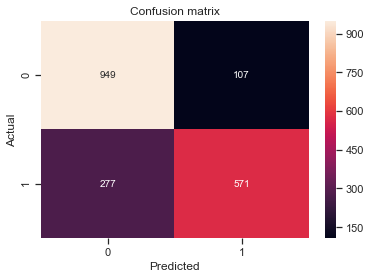

In [537]:
fig, ax = plt.subplots()
sns.heatmap(confusion_matrix(y_test, ypred_grid_logregcountvect_params), annot=True, fmt='d', ax=ax)
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('Confusion matrix')
plt.show()

In [538]:
print(classification_report(y_test, ypred_grid_logregcountvect_params))

              precision    recall  f1-score   support

           0       0.77      0.90      0.83      1056
           1       0.84      0.67      0.75       848

    accuracy                           0.80      1904
   macro avg       0.81      0.79      0.79      1904
weighted avg       0.80      0.80      0.79      1904



Sensitivity: 0.7983490566037735
Specificity: 0.7566287878787878


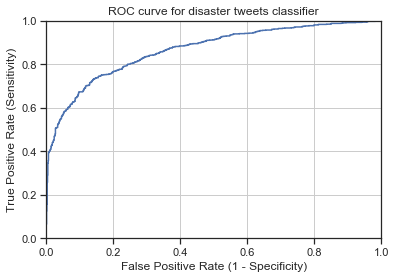

In [539]:
#see how sensitivity and specificity are affected by various thresholds, without actually changing the threshold
#AUC is the percentage of the ROC plot that is underneath the curve
#AUC is useful as a single number summary of classifier performance.
#If you randomly chose one positive and one negative observation, AUC represents the likelihood that your classifier will assign a higher predicted probability to the positive observation.

y_pred_prob = grid_logregcountvect_params.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_prob)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC curve for disaster tweets classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

# define a function that accepts a threshold and prints sensitivity and specificity
def evaluate_threshold(threshold):
    print('Sensitivity:', tpr[thresholds > threshold][-1])
    print('Specificity:', 1 - fpr[thresholds > threshold][-1])

evaluate_threshold(0.3)

In [540]:
print(metrics.roc_auc_score(y_test, y_pred_prob))

0.8659697282375642


# Pipeline 2: logreg + tfidf

In [541]:
##2nd combination: logreg + tfidf
tfidf= TfidfVectorizer()
ct = make_column_transformer(
    (tfidf, 'text_nourl_lowercase_nopunc'),
    (StandardScaler(), cols_to_scale))
logreg = LogisticRegression(solver='liblinear')
pipe_logregtfidf = make_pipeline(ct, logreg)
pipe_logregtfidf.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('tfidfvectorizer',
                                                  TfidfVectorizer(),
                                                  'text_nourl_lowercase_nopunc'),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  ['url_count', 'char_len',
                                                   'word_count',
                                                   'char_per_word',
                                                   'stopwords_count',
                                                   'polarity', 'subjectivity',
                                                   '#tweet_count', '@_count',
                                                   '!_count', '._count',
                                                   'punc_count',
                                

In [542]:
pipe_logregtfidf_params = {}
pipe_logregtfidf_params['logisticregression__penalty'] = ['l1', 'l2']
pipe_logregtfidf_params['logisticregression__C'] = [0.1, 1, 10]
pipe_logregtfidf_params['columntransformer__tfidfvectorizer__ngram_range'] = [(1, 1), (1, 2)]
pipe_logregtfidf_params['columntransformer__tfidfvectorizer__tokenizer'] = [stem_tokenize_removestop, stem_tokenize_leavestop, lemm_tokenize_removestop, lemm_tokenize_leavestop, tokenize_removestop, tokenize_leavestop]

grid_logregtfidf_params = GridSearchCV(pipe_logregtfidf, pipe_logregtfidf_params, cv=5, scoring='accuracy')
grid_logregtfidf_params.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('tfidfvectorizer',
                                                                         TfidfVectorizer(),
                                                                         'text_nourl_lowercase_nopunc'),
                                                                        ('standardscaler',
                                                                         StandardScaler(),
                                                                         ['url_count',
                                                                          'char_len',
                                                                          'word_count',
                                                                          'char_per_word',
                                                                          'stopwords_count',
    

In [543]:
results = pd.DataFrame(grid_logregtfidf_params.cv_results_)
results.sort_values('rank_test_score')

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
47       1.845165      0.077756         0.415981        0.022181   
59       1.219900      0.040495         0.291946        0.013853   
53       1.038627      0.067776         0.277001        0.009575   
23       0.961629      0.031683         0.269540        0.008239   
35       0.679605      0.021551         0.211930        0.004935   
71       0.906828      0.023552         0.222280        0.010575   
65       0.839877      0.033067         0.217333        0.019115   
9        1.422303      0.089368         0.395581        0.014623   
41       1.518444      0.164794         0.374960        0.034878   
29       0.658960      0.015077         0.214376        0.013460   
21       0.858777      0.012338         0.266168        0.006190   
3        1.191288      0.028174         0.345150        0.010462   
15       0.827929      0.046921         0.258468        0.009623   
11       1.411314      0.068154         0.386350        0.027523   
33       0.654000      0.022523         0.203230        0.016379   
5        1.249495      0.078211         0.353853        0.007382   
27       0.658549      0.016492         0.211472        0.010479   
17       0.830738      0.022453         0.258196        0.016463   
8        1.427086      0.013095         0.371657        0.031924   
45       1.688483      0.115242         0.427327        0.010532   
20       0.889615      0.021851         0.206840        0.007816   
51       1.068954      0.056933         0.276400        0.010242   
39       1.450244      0.050479         0.393752        0.023216   
57       1.182009      0.030160         0.290435        0.013327   
10       1.504573      0.077280         0.341526        0.021881   
63       0.812052      0.017683         0.224944        0.015323   
69       0.930769      0.076295         0.234450        0.021052   
22       1.039570      0.074680         0.223453        0.019618   
2        1.231579      0.029592         0.289487        0.012593   
34       0.804192      0.014064         0.151617        0.008841   
..            ...           ...              ...             ...   
40       1.559148      0.048103         0.306429        0.014784   
38       1.456396      0.100099         0.350590        0.032148   
56       1.205477      0.049393         0.256722        0.017992   
50       1.029439      0.067633         0.221797        0.009977   
68       0.888575      0.034507         0.174801        0.010163   
62       0.813985      0.032649         0.168907        0.008683   
7        1.392477      0.124530         0.391982        0.016294   
19       0.861904      0.012066         0.269722        0.006269   
31       0.657833      0.023896         0.215130        0.015627   
1        1.200258      0.036561         0.348823        0.016245   
13       0.817068      0.034783         0.253836        0.005851   
25       0.677295      0.030824         0.215980        0.008554   
43       1.673905      0.096631         0.409497        0.029425   
37       1.447627      0.065255         0.373195        0.017815   
55       1.144550      0.060905         0.302693        0.009968   
67       0.838902      0.039070         0.229312        0.014873   
49       0.983002      0.058537         0.267722        0.009204   
61       0.781435      0.050076         0.234936        0.010719   
6        1.358321      0.089478         0.319727        0.012144   
18       0.887543      0.033750         0.205123        0.004212   
30       0.675609      0.036293         0.153252        0.007518   
0        1.245189      0.096140         0.303905        0.032010   
12       0.810727      0.010593         0.184453        0.001288   
42       1.703453      0.061851         0.357544        0.032423   
54       1.115177      0.049712         0.226044        0.002554   
66       0.901395      0.020841         0.173599        0.009624   
36       1.501822      0.052290         0.360830        0.03

In [544]:
grid_logregtfidf_params.best_score_

0.7947109104834762

In [545]:
grid_logregtfidf_params.best_params_

{'columntransformer__tfidfvectorizer__ngram_range': (1, 2),
 'columntransformer__tfidfvectorizer__tokenizer': <function __main__.stem_tokenize_leavestop(document)>,
 'logisticregression__C': 10,
 'logisticregression__penalty': 'l2'}

In [546]:
ypred_grid_logregtfidf_params  = grid_logregtfidf_params.predict(X_test)

In [547]:
confusion_logregtfidf = metrics.confusion_matrix(y_test, ypred_grid_logregtfidf_params)
TP = confusion_logregtfidf [1, 1]
TN = confusion_logregtfidf [0, 0]
FP = confusion_logregtfidf [0, 1]
FN = confusion_logregtfidf [1, 0]

#sensitivity
print(TP / float(TP + FN))

#specificity
print(TN / float(TN + FP))

#false positive rate
print(FP / float(TN + FP))

#precision
print(TP / float(TP + FP))

0.7275943396226415
0.8617424242424242
0.13825757575757575
0.8086500655307994


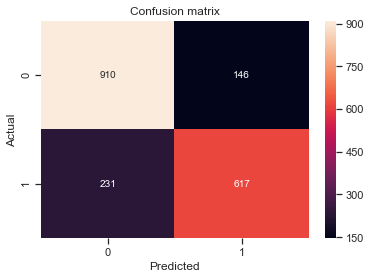

In [548]:
fig, ax = plt.subplots()
sns.heatmap(confusion_matrix(y_test, ypred_grid_logregtfidf_params), annot=True, fmt='d', ax=ax)
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('Confusion matrix')
plt.show()

In [549]:
print(classification_report(y_test, ypred_grid_logregtfidf_params))


              precision    recall  f1-score   support

           0       0.80      0.86      0.83      1056
           1       0.81      0.73      0.77       848

    accuracy                           0.80      1904
   macro avg       0.80      0.79      0.80      1904
weighted avg       0.80      0.80      0.80      1904



Sensitivity: 0.8360849056603774
Specificity: 0.71875


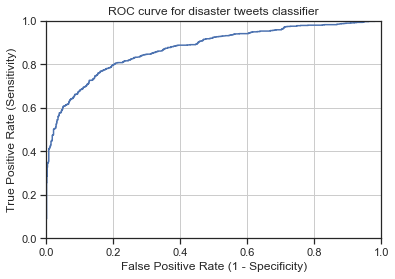

In [550]:
y_pred_prob = grid_logregtfidf_params.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_prob)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC curve for disaster tweets classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

evaluate_threshold(0.3)

In [551]:
print(metrics.roc_auc_score(y_test, y_pred_prob))

0.8733790960906231


# Pipeline 3: SGD + tfidf

In [552]:
tfidf= TfidfVectorizer()
ct = make_column_transformer(
    (tfidf, 'text_nourl_lowercase_nopunc'),
    (StandardScaler(), cols_to_scale))
sgd = SGDClassifier()
pipe_sgdtfidf = make_pipeline(ct, sgd)
pipe_sgdtfidf.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('tfidfvectorizer',
                                                  TfidfVectorizer(),
                                                  'text_nourl_lowercase_nopunc'),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  ['url_count', 'char_len',
                                                   'word_count',
                                                   'char_per_word',
                                                   'stopwords_count',
                                                   'polarity', 'subjectivity',
                                                   '#tweet_count', '@_count',
                                                   '!_count', '._count',
                                                   'punc_count',
                                

In [555]:
pipe_sgdtfidf_params = {}
pipe_sgdtfidf_params['sgdclassifier__loss'] = ['hinge', 'log']
pipe_sgdtfidf_params['sgdclassifier__penalty']  = ['l1', 'l2', 'elasticnet']
pipe_sgdtfidf_params['sgdclassifier__alpha'] = [.0001, .0005, .001]   
pipe_sgdtfidf_params['columntransformer__tfidfvectorizer__ngram_range'] = [(1, 1), (1, 2)]
pipe_sgdtfidf_params['columntransformer__tfidfvectorizer__tokenizer'] = [stem_tokenize_removestop, stem_tokenize_leavestop, lemm_tokenize_removestop, lemm_tokenize_leavestop, tokenize_removestop, tokenize_leavestop]

grid_sgdtfidf_params = GridSearchCV(pipe_sgdtfidf, pipe_sgdtfidf_params, cv=5, scoring='accuracy')
grid_sgdtfidf_params.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('tfidfvectorizer',
                                                                         TfidfVectorizer(),
                                                                         'text_nourl_lowercase_nopunc'),
                                                                        ('standardscaler',
                                                                         StandardScaler(),
                                                                         ['url_count',
                                                                          'char_len',
                                                                          'word_count',
                                                                          'char_per_word',
                                                                          'stopwords_count',
    

In [556]:
results = pd.DataFrame(grid_sgdtfidf_params.cv_results_)
results.sort_values('rank_test_score')

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
128       1.827452      0.073547         0.405522        0.020935   
25        1.469245      0.034788         0.420547        0.010812   
43        0.972348      0.046749         0.285057        0.017414   
146       1.117606      0.026677         0.277561        0.014653   
61        1.024570      0.029392         0.303095        0.007524   
44        1.067027      0.030294         0.271018        0.013077   
151       1.009110      0.027941         0.282448        0.014135   
26        1.615082      0.078036         0.434488        0.035295   
56        1.138139      0.057044         0.278525        0.014532   
22        1.569187      0.052651         0.430959        0.022877   
58        1.050622      0.033253         0.297150        0.010728   
200       1.079019      0.033396         0.235198        0.013979   
79        0.740661      0.036120         0.220695        0.009975   
115       1.589471      0.053132         0.386048        0.003240   
182       0.922545      0.043162         0.222914        0.008996   
5         1.291975      0.053404         0.340094        0.012359   
40        0.996642      0.017050         0.270850        0.014195   
1         1.169432      0.016920         0.333136        0.007858   
94        0.758845      0.039932         0.231644        0.008911   
97        0.781814      0.052763         0.237547        0.023958   
92        0.872409      0.048965         0.216926        0.017059   
133       1.616799      0.117357         0.415420        0.031031   
8         1.415441      0.013445         0.374297        0.012626   
98        0.807560      0.054776         0.219816        0.007685   
7         1.287943      0.056196         0.372831        0.015639   
164       1.281175      0.066625         0.280270        0.009451   
4         1.213296      0.057472         0.339694        0.003194   
57        1.085518      0.036736         0.282782        0.011268   
181       0.779398      0.011747         0.229095        0.013602   
95        0.788676      0.012996         0.219500        0.008393   
..             ...           ...              ...             ...   
125       1.401991      0.067093         0.391007        0.035808   
143       1.624470      0.014150         0.426968        0.017887   
179       1.138188      0.026053         0.292557        0.008983   
161       0.987140      0.019081         0.271109        0.004298   
84        0.747256      0.032340         0.226104        0.006353   
33        1.592123      0.048730         0.426982        0.020279   
215       0.842660      0.019165         0.217223        0.007739   
117       1.385947      0.077283         0.383071        0.012237   
153       0.988379      0.008778         0.276079        0.010020   
69        1.055972      0.013580         0.298957        0.011261   
171       1.128275      0.025828         0.289110        0.006451   
207       0.847202      0.015271         0.229195        0.016215   
138       1.734673      0.093763         0.436238        0.016341   
197       0.834754      0.014355         0.227010        0.013323   
105       0.637834      0.012212         0.193831        0.016360   
174       1.151305      0.024213         0.303796        0.016655   
210       0.849089      0.020728         0.230291        0.017173   
189       0.805499      0.011055         0.232603        0.009550   
120       1.388121      0.049009         0.374615        0.020074   
15        1.385293      0.028282         0.374437        0.009738   
156       0.998579      0.007526         0.275962        0.005462   
192       0.797196      0.011416         0.234752        0.009704   
177       1.105626      0.006775         0.298817        0.008568   
51        0.975953      0.024186         0.270907        0.013174   
141       1.613257      0.018445         0.418395        0.016090   
87        0.734865      0.007774         0.230539        0.008931   
213

In [557]:
grid_sgdtfidf_params.best_score_

0.7903332407280921

In [558]:
grid_sgdtfidf_params.best_params_

{'columntransformer__tfidfvectorizer__ngram_range': (1, 2),
 'columntransformer__tfidfvectorizer__tokenizer': <function __main__.stem_tokenize_leavestop(document)>,
 'sgdclassifier__alpha': 0.0001,
 'sgdclassifier__loss': 'hinge',
 'sgdclassifier__penalty': 'elasticnet'}

In [559]:
ypred_grid_sgdtfidf_params  = grid_sgdtfidf_params.predict(X_test)

In [560]:
confusion_sgdtfidf = metrics.confusion_matrix(y_test, ypred_grid_sgdtfidf_params)
TP = confusion_sgdtfidf[1, 1]
TN = confusion_sgdtfidf[0, 0]
FP = confusion_sgdtfidf[0, 1]
FN = confusion_sgdtfidf[1, 0]

#sensitivity
print(TP / float(TP + FN))

#specificity
print(TN / float(TN + FP))

#false positive rate
print(FP / float(TN + FP))

#precision
print(TP / float(TP + FP))

0.7417452830188679
0.8664772727272727
0.13352272727272727
0.8168831168831169


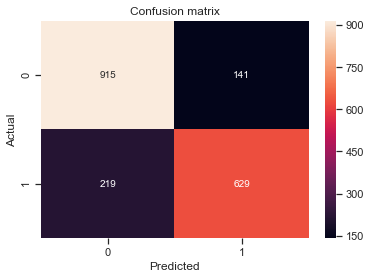

In [561]:
fig, ax = plt.subplots()
sns.heatmap(confusion_matrix(y_test, ypred_grid_sgdtfidf_params), annot=True, fmt='d', ax=ax)
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('Confusion matrix')
plt.show()

In [562]:
print(classification_report(y_test, ypred_grid_sgdtfidf_params))

              precision    recall  f1-score   support

           0       0.81      0.87      0.84      1056
           1       0.82      0.74      0.78       848

    accuracy                           0.81      1904
   macro avg       0.81      0.80      0.81      1904
weighted avg       0.81      0.81      0.81      1904



# Pipeline 4: SVM + tfidf

In [565]:
#3rd combination: SVM + TFIDF 
from sklearn import svm
tfidf= TfidfVectorizer()
ct = make_column_transformer(
    (tfidf, 'text_nourl_lowercase_nopunc'),
    (StandardScaler(), cols_to_scale))
svmachine = svm.SVC()
pipe_svmachinetfidf = make_pipeline(ct, svmachine)
pipe_svmachinetfidf.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('tfidfvectorizer',
                                                  TfidfVectorizer(),
                                                  'text_nourl_lowercase_nopunc'),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  ['url_count', 'char_len',
                                                   'word_count',
                                                   'char_per_word',
                                                   'stopwords_count',
                                                   'polarity', 'subjectivity',
                                                   '#tweet_count', '@_count',
                                                   '!_count', '._count',
                                                   'punc_count',
                                

In [566]:
pipe_svmachinetfidf_params = {}
pipe_svmachinetfidf_params['svc__kernel'] = ['linear', 'rbf']
pipe_svmachinetfidf_params['svc__C'] = [1, 0.5]
pipe_svmachinetfidf_params['svc__gamma'] = [0.01, 0.7]
pipe_svmachinetfidf_params['svc__degree'] = [2, 3]
pipe_svmachinetfidf_params['columntransformer__tfidfvectorizer__ngram_range'] = [(1, 1), (1, 2)]
pipe_svmachinetfidf_params['columntransformer__tfidfvectorizer__tokenizer'] = [stem_tokenize_removestop, stem_tokenize_leavestop, lemm_tokenize_removestop, lemm_tokenize_leavestop, tokenize_removestop, tokenize_leavestop]

grid_svmachinetfidf_params = GridSearchCV(pipe_svmachinetfidf, pipe_svmachinetfidf_params, cv=5, scoring='accuracy')
grid_svmachinetfidf_params.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('tfidfvectorizer',
                                                                         TfidfVectorizer(),
                                                                         'text_nourl_lowercase_nopunc'),
                                                                        ('standardscaler',
                                                                         StandardScaler(),
                                                                         ['url_count',
                                                                          'char_len',
                                                                          'word_count',
                                                                          'char_per_word',
                                                                          'stopwords_count',
    

In [568]:
results_grid_svmachinetfidf = pd.DataFrame(grid_svmachinetfidf_params.cv_results_)
results_grid_svmachinetfidf.sort_values('rank_test_score')

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
46        3.255288      0.130909         0.541764        0.021287   
44        3.318500      0.033224         0.539779        0.012835   
42        3.351433      0.168163         0.559904        0.040696   
40        3.322486      0.146990         0.549156        0.018608   
48        4.530276      0.150491         0.656250        0.023736   
50        4.598052      0.182717         0.650261        0.019220   
52        4.497551      0.198093         0.662042        0.027208   
54        4.410215      0.169146         0.644470        0.024020   
80        4.151888      0.065001         0.591218        0.009364   
84        4.100017      0.067628         0.582856        0.007161   
86        4.118982      0.095355         0.583838        0.008639   
82        4.100832      0.066494         0.579249        0.002223   
60        3.592574      0.064940         0.637112        0.003751   
58        3.600171      0.082979         0.635507        0.003051   
62        3.589388      0.084596         0.644480        0.015998   
56        3.587800      0.071821         0.635910        0.002858   
160       5.639515      0.513995         0.620141        0.004522   
162       5.679996      0.485617         0.638299        0.012429   
166       5.611789      0.502908         0.615553        0.003302   
164       5.622760      0.503572         0.618742        0.004952   
114       7.488963      1.019813         0.999939        0.003004   
116       7.498538      1.007222         1.050589        0.057113   
118       7.675876      1.034000         1.021674        0.046222   
112       7.530059      1.032145         1.047995        0.057716   
182       7.252134      0.844341         0.894025        0.009525   
176       7.413180      0.749196         0.911166        0.059885   
178       7.454466      0.771068         0.901627        0.010983   
180       7.245119      0.811799         0.894527        0.007017   
148       7.356494      0.475873         0.963404        0.012693   
150       7.434054      0.773662         0.968221        0.054868   
..             ...           ...              ...             ...   
109       3.630289      0.011161         0.747002        0.001783   
105       3.686741      0.080662         0.756778        0.019156   
141       3.330498      0.074459         0.669215        0.021137   
137     205.018426    403.066541         0.721672        0.094084   
169       3.246479      0.016723         0.629313        0.004048   
173       3.297919      0.052382         0.644417        0.013180   
95        3.742390      0.010584         0.802456        0.000796   
91        3.702889      0.037767         0.795473        0.012656   
27        4.304867      0.021087         0.972223        0.050477   
31        4.406801      0.183687         0.972605        0.049880   
59        3.858289      0.003365         0.837965        0.004686   
63        3.867044      0.006361         0.839373        0.002856   
155       5.286733      0.087244         1.100276        0.015788   
187       5.055807      0.025485         1.058391        0.015411   
159       5.128147      0.110449         1.085690        0.023826   
191       5.062271      0.030548         1.070358        0.018201   
123       5.472966      0.194292         1.187223        0.046104   
127       5.363874      0.010320         1.157110        0.004609   
15        3.419456      0.007746         0.736441        0.004018   
11        3.611527      0.361956         0.777526        0.056647   
79        2.907805      0.009070         0.599020        0.001846   
75        2.921784      0.032316         0.597408        0.001899   
47        3.367395      0.028102         0.700730        0.031885   
43        3.209807      0.141329         0.697346        0.046909   
175       3.874994      0.136579         0.765080        0.017932   
171       3.746030      0.017454         0.748097        0.014555   
139

In [569]:
grid_svmachinetfidf_params.best_score_

0.7996107510080412

In [570]:
grid_svmachinetfidf_params.best_params_

{'columntransformer__tfidfvectorizer__ngram_range': (1, 1),
 'columntransformer__tfidfvectorizer__tokenizer': <function __main__.lemm_tokenize_removestop(document)>,
 'svc__C': 0.5,
 'svc__degree': 2,
 'svc__gamma': 0.01,
 'svc__kernel': 'linear'}

In [571]:
ypred_grid_svmachinetfidf_params  = grid_svmachinetfidf_params.predict(X_test)

In [573]:
confusion_svmachinetfidf = metrics.confusion_matrix(y_test, ypred_grid_svmachinetfidf_params)
TP = confusion_svmachinetfidf[1, 1]
TN = confusion_svmachinetfidf[0, 0]
FP = confusion_svmachinetfidf[0, 1]
FN = confusion_svmachinetfidf[1, 0]

#sensitivity
print(TP / float(TP + FN))

#specificity
print(TN / float(TN + FP))

#false positive rate
print(FP / float(TN + FP))

#precision
print(TP / float(TP + FP))

0.6662735849056604
0.9109848484848485
0.08901515151515152
0.8573596358118362


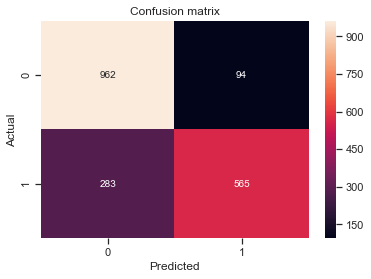

In [574]:
fig, ax = plt.subplots()
sns.heatmap(confusion_matrix(y_test, ypred_grid_svmachinetfidf_params), annot=True, fmt='d', ax=ax)
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('Confusion matrix')
plt.show()

In [575]:
print(classification_report(y_test, ypred_grid_svmachinetfidf_params))

              precision    recall  f1-score   support

           0       0.77      0.91      0.84      1056
           1       0.86      0.67      0.75       848

    accuracy                           0.80      1904
   macro avg       0.82      0.79      0.79      1904
weighted avg       0.81      0.80      0.80      1904



In [582]:
grid_sgdtfidf_params.best_params_

{'columntransformer__tfidfvectorizer__ngram_range': (1, 2),
 'columntransformer__tfidfvectorizer__tokenizer': <function __main__.stem_tokenize_leavestop(document)>,
 'sgdclassifier__alpha': 0.0001,
 'sgdclassifier__loss': 'hinge',
 'sgdclassifier__penalty': 'elasticnet'}

In [584]:
df_kagglesubmissiontest = pd.read_csv('test.csv')
df_kagglesubmissiontest.head()

id keyword location                                               text
0   0     NaN      NaN                 Just happened a terrible car crash
1   2     NaN      NaN  Heard about #earthquake is different cities, s...
2   3     NaN      NaN  there is a forest fire at spot pond, geese are...
3   9     NaN      NaN           Apocalypse lighting. #Spokane #wildfires
4  11     NaN      NaN      Typhoon Soudelor kills 28 in China and Taiwan

In [586]:
df_kagglesubmissiontest['url_count'] = df_kagglesubmissiontest.text.apply(lambda x: url_count(x))
df_kagglesubmissiontest['text_nourl'] = df_kagglesubmissiontest.text.apply(lambda x: remove_url(x))

df_kagglesubmissiontest['char_len'] = df_kagglesubmissiontest.text_nourl.str.len()
df_kagglesubmissiontest['word_count'] = df_kagglesubmissiontest.text_nourl.apply(lambda x: len(x.split()))
df_kagglesubmissiontest['char_per_word'] = df_kagglesubmissiontest.char_len/df_kagglesubmissiontest.word_count

from nltk.corpus import stopwords
stop = stopwords.words('english')
df_kagglesubmissiontest['stopwords_count'] = df_kagglesubmissiontest.text_nourl.apply(lambda x: len([y for y in x.split() if y in stop]))

from textblob import TextBlob
df_kagglesubmissiontest['polarity'] = df_kagglesubmissiontest.text_nourl.map(lambda x: TextBlob(x).sentiment.polarity)
df_kagglesubmissiontest['subjectivity'] = df_kagglesubmissiontest.text_nourl.map(lambda x: TextBlob(x).sentiment.subjectivity)

#Creating seperate features for @, ! and . as these may be common characters in tweets
#punc_count will count all the punctuations, including @, ! and . 
df_kagglesubmissiontest['#tweet_count'] = df_kagglesubmissiontest.text_nourl.apply(lambda x: len(re.findall('#\w*[a-zA-Z]\w*', x))) 
df_kagglesubmissiontest['#tweet_list'] = df_kagglesubmissiontest.text_nourl.apply(lambda x: re.findall('#\w*[a-zA-Z]\w*', x)) 
df_kagglesubmissiontest['@_count'] = df_kagglesubmissiontest.text_nourl.apply(lambda x: x.count('@'))
df_kagglesubmissiontest['!_count'] = df_kagglesubmissiontest.text_nourl.apply(lambda x: x.count('!'))
df_kagglesubmissiontest['._count'] = df_kagglesubmissiontest.text_nourl.apply(lambda x: x.count('.'))
df_kagglesubmissiontest['punc_count'] = df_kagglesubmissiontest.text_nourl.apply(lambda x: len(re.findall('[.?"\'`\,\-\!:;\(\)\[\]\\/“”]+?', x)))

df_kagglesubmissiontest['numerics_count'] = df_kagglesubmissiontest.text_nourl.apply(lambda x: len([y for y in x.split() if y.isdigit()]))
df_kagglesubmissiontest['uppercaseword_count'] = df_kagglesubmissiontest.text_nourl.apply(lambda x: len([y for y in x.split() if y.isupper()]))

#Later we will create the document-term matrix using text_nourl_lowercase_nopunc
df_kagglesubmissiontest['text_nourl_lowercase_nopunc'] = df_kagglesubmissiontest.text_nourl.apply(lambda x: re.sub(r'[^\w\s]', '', x.lower()))

df_kagglesubmissiontest

id   keyword                          location  \
0         0       NaN                               NaN   
1         2       NaN                               NaN   
2         3       NaN                               NaN   
3         9       NaN                               NaN   
4        11       NaN                               NaN   
5        12       NaN                               NaN   
6        21       NaN                               NaN   
7        22       NaN                               NaN   
8        27       NaN                               NaN   
9        29       NaN                               NaN   
10       30       NaN                               NaN   
11       35       NaN                               NaN   
12       42       NaN                               NaN   
13       43       NaN                               NaN   
14       45       NaN                               NaN   
15       46    ablaze                            London   
16       47    ablaze    Niall's place | SAF 12 SQUAD |   
17       51    ablaze                           NIGERIA   
18       58    ablaze                    Live On Webcam   
19       60    ablaze          Los Angeles, Califnordia   
20       69    ablaze                    threeonefive.    
21       70    ablaze                  Washington State   
22       72    ablaze                Whoop Ass, Georgia   
23       75    ablaze                             India   
24       84    ablaze                               NaN   
25       87    ablaze              scarborough, ontario   
26       88    ablaze                               NaN   
27       90    ablaze      121 N La Salle St, Suite 500   
28       94    ablaze                         Wandering   
29       99  accident                      Homewood, PA   
...     ...       ...                               ...   
3233  10756  wreckage                            Mumbai   
3234  10757  wreckage                               NaN   
3235  10758  wreckage                             India   
3236  10761  wreckage                            Mumbai   
3237  10762  wreckage                            Canada   
3238  10773  wreckage                               NaN   
3239  10778  wreckage                            Mumbai   
3240  10781  wreckage                        our galaxy   
3241  10791   wrecked         Sunny Southern California   
3242  10792   wrecked                 Plymouth, England   
3243  10796   wrecked      Deep in the heart of LibLand   
3244  10797   wrecked                               NaN   
3245  10801   wrecked                    Canada,Ontario   
3246  10804   wrecked                        Love Reiss   
3247  10806   wrecked                Seattle Washington   
3248  10807   wrecked  Acey mountain islanddåÇTorontoåÈ   
3249  10816   wrecked                       los angeles   
3250  10820   wrecked                 Brussels, Belgium   
3251  10828   wrecked                               NaN   
3252  10836       NaN                               NaN   
3253  10838       NaN                               NaN   
3254  10845       NaN                               NaN   
3255  10856       NaN                               NaN   
3256  10857       NaN                               NaN   
3257  10858       NaN                               NaN   
3258  10861       NaN                               NaN   
3259  10865       NaN                               NaN   
3260  10868       NaN                               NaN   
3261  10874       NaN                               NaN   
3262  10875       NaN                               NaN   

                                                   text  url_count  \
0                    Just happened a terrible car crash          0   
1     Heard about #earthquake is different cities, s...          0   
2     there is a forest fire at spot pond, geese are...          0   
3              Apocalypse lighting. #Spokane #wildfires          0   


In [588]:
df_kagglesubmissiontest['target'] = grid_sgdtfidf_params.predict(df_kagglesubmissiontest)

C:\Users\Pamela Sin\Documents\Jupyter\lib\site-packages\sklearn\compose\_column_transformer.py:440: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)


In [589]:
df_kagglesubmissiontest

id   keyword                          location  \
0         0       NaN                               NaN   
1         2       NaN                               NaN   
2         3       NaN                               NaN   
3         9       NaN                               NaN   
4        11       NaN                               NaN   
5        12       NaN                               NaN   
6        21       NaN                               NaN   
7        22       NaN                               NaN   
8        27       NaN                               NaN   
9        29       NaN                               NaN   
10       30       NaN                               NaN   
11       35       NaN                               NaN   
12       42       NaN                               NaN   
13       43       NaN                               NaN   
14       45       NaN                               NaN   
15       46    ablaze                            London   
16       47    ablaze    Niall's place | SAF 12 SQUAD |   
17       51    ablaze                           NIGERIA   
18       58    ablaze                    Live On Webcam   
19       60    ablaze          Los Angeles, Califnordia   
20       69    ablaze                    threeonefive.    
21       70    ablaze                  Washington State   
22       72    ablaze                Whoop Ass, Georgia   
23       75    ablaze                             India   
24       84    ablaze                               NaN   
25       87    ablaze              scarborough, ontario   
26       88    ablaze                               NaN   
27       90    ablaze      121 N La Salle St, Suite 500   
28       94    ablaze                         Wandering   
29       99  accident                      Homewood, PA   
...     ...       ...                               ...   
3233  10756  wreckage                            Mumbai   
3234  10757  wreckage                               NaN   
3235  10758  wreckage                             India   
3236  10761  wreckage                            Mumbai   
3237  10762  wreckage                            Canada   
3238  10773  wreckage                               NaN   
3239  10778  wreckage                            Mumbai   
3240  10781  wreckage                        our galaxy   
3241  10791   wrecked         Sunny Southern California   
3242  10792   wrecked                 Plymouth, England   
3243  10796   wrecked      Deep in the heart of LibLand   
3244  10797   wrecked                               NaN   
3245  10801   wrecked                    Canada,Ontario   
3246  10804   wrecked                        Love Reiss   
3247  10806   wrecked                Seattle Washington   
3248  10807   wrecked  Acey mountain islanddåÇTorontoåÈ   
3249  10816   wrecked                       los angeles   
3250  10820   wrecked                 Brussels, Belgium   
3251  10828   wrecked                               NaN   
3252  10836       NaN                               NaN   
3253  10838       NaN                               NaN   
3254  10845       NaN                               NaN   
3255  10856       NaN                               NaN   
3256  10857       NaN                               NaN   
3257  10858       NaN                               NaN   
3258  10861       NaN                               NaN   
3259  10865       NaN                               NaN   
3260  10868       NaN                               NaN   
3261  10874       NaN                               NaN   
3262  10875       NaN                               NaN   

                                                   text  url_count  \
0                    Just happened a terrible car crash          0   
1     Heard about #earthquake is different cities, s...          0   
2     there is a forest fire at spot pond, geese are...          0   
3              Apocalypse lighting. #Spokane #wildfires          0   


In [592]:
submission = df_kagglesubmissiontest.loc[:,['id', 'target']]
submission.head()

id  target
0   0       1
1   2       0
2   3       1
3   9       1
4  11       1

In [593]:
submission.to_csv (r'submission.csv', index = False, header=True)

## [Section 7: Observations and analysis]
1. Conclusion:
   Assuming stratification, a dumb model predicting the majority class has a 57% accuracy. 
   The models tested all had an accuracy close to 80%
   Pipeline 3 - Best F1 score = 0.81
   
   Best model and parameters: 
   - TFIDF
   - ngram_range = (1, 2)
   - Don't remove stop words
   - SGD
   - alpha = 0.0001
   - loss = 'hinge'
   - penalty = 'elasticnet
   
   Score of 0.79252 on Kaggle


2. A higher accuracy might have been achieved by implementing 3. 
   
   
3. Improvements proposed:
   Could try more cleaning of data
   Could try out stratification
   Could try out PCA
   Could try Kbest on numeric features
   Could use boosting